<a href="https://colab.research.google.com/github/robeespi/NYC-taxi-2013-analysis-modeling-visualization/blob/main/Exercise_NYC_Taxi_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting the environment




In [ ]:
#@title
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls gdrive/MyDrive/elula/

355pickups.csv
d.csv
fare_data_df.parquet
fare_data_df.pkl
fare_data_june.parquet
fares_df.pkl
nyctaxi2013_june6_merged
nyctaxi2013_june_merged
nyctaxidb.sqlite
nyctaxitripdata2013db.sqlite
pickup355_df_adressess_zipcode.csv
pickup_df_zipcode_addresses
pickup_df_zipcode_addresses.csv
taxi_car_occupancy_pivot.csv
taxidf_groupedby_medallion_dayofweek_pickup_hour.csv
taxi_df_june.parquet
taxi_df_june_twopays.parquet
taxi_df.parquet
taxi_df.pkl
taxi_vis_df_perhour2.csv
taxi_vis_df_perhour.csv
top10pickups.csv
trip_data
trip_data_4.csv
trip_data_june.parquet
trip_fare
trip_fare_4.csv
trips_df2_june.parquet
trips_df2.parquet
trips_df2.pkl


In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 24.58GB
Used: 595.60MB
Percentage: 3.6%


In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3
from scipy.stats.mstats import winsorize
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
     \ 148.9MB 826kB/s
     |████████████████████████████████| 6.5MB 5.1MB/s 
     |████████████████████████████████| 225kB 42.3MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759570 sha256=ebc0864733aaee5ddfa516f2e8d260efbfb63e0929dcee4db45827686ab81226
  Stored in directory: /tmp/pip-ephem-wheel-cache-lm61r_8s/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl 

In [ ]:
# Initialize Basemap
import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

# Read datasets

In [ ]:
import pandas as pd
trip_data = pd.read_csv('gdrive/MyDrive/elula/trip_data/trip_data_6.csv', parse_dates=[' pickup_datetime', ' dropoff_datetime'])
# Remove Whitespace in Column Names
trip_data.columns = [x.strip().replace(' ', '') for x in trip_data.columns]
trip_data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,D1C79CF706C80D3A1DC7FBCA6CD56E43,DAC7742E8F00034774098DBC6B4FF2B7,CMT,1,N,2013-06-03 00:02:12,2013-06-03 00:10:07,1,474,1.3,-73.981583,40.773529,-73.981827,40.782124
1,3567E8B49FEBFCBB587F1864D723D5C8,430B8022563CDE1D51D44786DFD8D6CB,CMT,1,N,2013-06-03 00:03:03,2013-06-03 00:19:27,1,982,4.9,-73.999565,40.728367,-73.952927,40.729546
2,4220E1995D36A40DF34664AD33ED13F6,48A1C9C9300AFC7BDBB718CE308EE45A,CMT,2,N,2013-06-03 00:01:30,2013-06-03 00:28:11,1,1745,17.7,-73.788445,40.641151,-73.985451,40.744194
3,440900089FF528A873424DED689C77A3,E6A63B40E565A8A03AF32E0B138F5EB1,CMT,1,N,2013-06-03 00:04:14,2013-06-03 00:27:50,1,1415,12.1,-73.862816,40.768875,-74.008797,40.738842
4,16129167D9E7B0846DBA3D04B78E1B8D,227A03FC03CF429DFC9EAFF0AE8BA579,CMT,1,N,2013-06-03 00:04:53,2013-06-03 00:10:46,1,353,1.1,-73.964905,40.806881,-73.962349,40.794987


In [ ]:
trip_data.to_parquet('gdrive/MyDrive/elula/trip_data_june.parquet')

In [ ]:
import pandas as pd
trip_data_df = pd.read_parquet('gdrive/MyDrive/elula/trip_data_june.parquet')
trip_data_df.head()

,index,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,123,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,None,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531
1,145,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,None,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992
2,3758654,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,None,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596
3,3758665,AE6D169855A4363F119879EB67476A26,287758B2FB350B30D67B51809D127630,VTS,1,None,2013-06-01 00:00:00,2013-06-01 00:14:00,1,840,10.25,-73.784386,40.648624,-73.866974,40.736397
4,3758674,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,None,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011


In [ ]:
query_string1 = '''
                select * from trips order by pickup_datetime asc
'''

In [ ]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('gdrive/MyDrive/elula/trip_data/nyctaxitripdata2013db.sqlite')
# Confirm data is being returned from this query
trip_data_df = pd.read_sql_query(query_string1, con)
# Verify that result of SQL query is stored in the dataframe
trip_data_df.head()

,index,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,123,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,None,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531
1,145,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,None,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992
2,3758654,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,None,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596
3,3758665,AE6D169855A4363F119879EB67476A26,287758B2FB350B30D67B51809D127630,VTS,1,None,2013-06-01 00:00:00,2013-06-01 00:14:00,1,840,10.25,-73.784386,40.648624,-73.866974,40.736397
4,3758674,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,None,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011


In [ ]:
con.close()

In [ ]:
trip_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14385456 entries, 0 to 14385455
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   index               int64  
 1   medallion           object 
 2   hack_license        object 
 3   vendor_id           object 
 4   rate_code           int64  
 5   store_and_fwd_flag  object 
 6   pickup_datetime     object 
 7   dropoff_datetime    object 
 8   passenger_count     int64  
 9   trip_time_in_secs   int64  
 10  trip_distance       float64
 11  pickup_longitude    float64
 12  pickup_latitude     float64
 13  dropoff_longitude   float64
 14  dropoff_latitude    float64
dtypes: float64(5), int64(4), object(6)
memory usage: 1.6+ GB


In [ ]:
import sqlite3
# Create a sqlite3 connection to nyctaxidb
cnxn = sqlite3.connect('gdrive/MyDrive/elula/trip_data/nyctaxitripdata2013db.sqlite')

In [ ]:
# Create trips table
trip_data.to_sql('trips',cnxn)

In [ ]:
query_string2 = '''
                select * from fares order by pickup_datetime asc
'''

In [ ]:
import sqlite3
import pandas as pd
# Connect to the existing fleetriskdb
con = sqlite3.connect('gdrive/MyDrive/elula/trip_data/nyctaxitripdata2013db.sqlite')
# Confirm data is being returned from this query
fare_data_df = pd.read_sql_query(query_string2, con)
# Verify that result of SQL query is stored in the dataframe
fare_data_df.head()

,index,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,123,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,2013-06-01 00:00:00,CRD,10.0,0.5,0.5,2.1,0.0,13.1
1,145,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,2013-06-01 00:00:00,CSH,9.5,0.5,0.5,0.0,0.0,10.5
2,3758654,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,2013-06-01 00:00:00,CSH,11.0,0.5,0.5,0.0,0.0,12.0
3,3758665,AE6D169855A4363F119879EB67476A26,287758B2FB350B30D67B51809D127630,VTS,2013-06-01 00:00:00,CSH,28.0,0.5,0.5,0.0,0.0,29.0
4,3758674,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,2013-06-01 00:00:00,CRD,15.0,0.5,0.5,3.1,0.0,19.1


In [ ]:
con.close()

In [ ]:
import pandas as pd
fare_data = pd.read_csv('gdrive/MyDrive/elula/trip_fare/trip_fare_6.csv', parse_dates = [' pickup_datetime'])
# Remove whitespace from column names
fare_data.columns = [x.strip().replace(' ', '') for x in fare_data.columns]
fare_data.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,D1C79CF706C80D3A1DC7FBCA6CD56E43,DAC7742E8F00034774098DBC6B4FF2B7,CMT,2013-06-03 00:02:12,CRD,7.5,0.5,0.5,2.12,0.00,10.62
1,3567E8B49FEBFCBB587F1864D723D5C8,430B8022563CDE1D51D44786DFD8D6CB,CMT,2013-06-03 00:03:03,CRD,17.0,0.5,0.5,3.60,0.00,21.60
2,4220E1995D36A40DF34664AD33ED13F6,48A1C9C9300AFC7BDBB718CE308EE45A,CMT,2013-06-03 00:01:30,CRD,52.0,0.0,0.5,5.00,5.33,62.83
3,440900089FF528A873424DED689C77A3,E6A63B40E565A8A03AF32E0B138F5EB1,CMT,2013-06-03 00:04:14,CRD,34.5,0.5,0.5,7.10,0.00,42.60
4,16129167D9E7B0846DBA3D04B78E1B8D,227A03FC03CF429DFC9EAFF0AE8BA579,CMT,2013-06-03 00:04:53,CRD,6.5,0.5,0.5,1.50,0.00,9.00


In [ ]:
fare_data_df.to_sql('fares',cnxn)

In [ ]:
fare_data_df.to_parquet('gdrive/MyDrive/elula/fare_data_june.parquet')

In [ ]:
import pandas as pd
fare_data = pd.read_parquet('gdrive/MyDrive/elula/fare_data_june.parquet')
fare_data.head()

,index,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,123,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,2013-06-01 00:00:00,CRD,10.0,0.5,0.5,2.1,0.0,13.1
1,145,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,2013-06-01 00:00:00,CSH,9.5,0.5,0.5,0.0,0.0,10.5
2,3758654,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,2013-06-01 00:00:00,CSH,11.0,0.5,0.5,0.0,0.0,12.0
3,3758665,AE6D169855A4363F119879EB67476A26,287758B2FB350B30D67B51809D127630,VTS,2013-06-01 00:00:00,CSH,28.0,0.5,0.5,0.0,0.0,29.0
4,3758674,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,2013-06-01 00:00:00,CRD,15.0,0.5,0.5,3.1,0.0,19.1


In [ ]:
fare_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14385456 entries, 0 to 14385455
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   index            int64  
 1   medallion        object 
 2   hack_license     object 
 3   vendor_id        object 
 4   pickup_datetime  object 
 5   payment_type     object 
 6   fare_amount      float64
 7   surcharge        float64
 8   mta_tax          float64
 9   tip_amount       float64
 10  tolls_amount     float64
 11  total_amount     float64
dtypes: float64(6), int64(1), object(5)
memory usage: 1.3+ GB


In [ ]:
fare_data.sort_values('pickup_datetime').tail()

,index,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
14385453,7969149,218ABD31CC8BC45592ECE73989DD630A,FF6E9ABD484E4F236953CB767E417401,CMT,2013-06-30 23:59:56,CSH,6.5,0.5,0.5,0.0,0.0,7.5
14385454,7969919,6F4220AA54EE75B0D11B55AD2B6922C1,FC47C36317B37FE32E1BBCA2FA0DBFAF,CMT,2013-06-30 23:59:56,CSH,11.5,0.5,0.5,0.0,0.0,12.5
14385451,7216193,11EE001B196E490E914A3BF4A2223150,5AC95CB40E97A5B601C68A8E1C85A50D,CMT,2013-06-30 23:59:56,CRD,4.0,0.5,0.5,1.0,0.0,6.0
14385452,7216584,B5728C575050CA7ABF88E5617CC6178E,14130B62DB7C3F45904632166988373F,CMT,2013-06-30 23:59:56,CRD,5.0,0.5,0.5,1.0,0.0,7.0
14385455,7978976,7D4F34EF0A251F3A6A8DF3CE4A098B8C,41A49F6C990711B3B89EDD76F72A7464,CMT,2013-06-30 23:59:56,CSH,8.0,0.5,0.5,0.0,0.0,9.0


In [ ]:
trip_data_df.shape[0]

14385456

In [ ]:
# Create a new dataframe for the cleaned trips data
trips_df = trip_data_df.copy()
# Check for nulls
trips_df.isnull().sum()

index                       0
medallion                   0
hack_license                0
vendor_id                   0
rate_code                   0
store_and_fwd_flag    7222712
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_time_in_secs           0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude         338
dropoff_latitude          338
dtype: int64

In [ ]:
#Eliminate store_and_fwd_flag column because it is unknow atribute
trips_df = trips_df.drop('store_and_fwd_flag', axis=1)
trips_df.columns

Index(['index', 'medallion', 'hack_license', 'vendor_id', 'rate_code', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], dtype='object')

In [ ]:
trips_df = trips_df[~trips_df.dropoff_latitude.isnull()]
trips_df = trips_df[~trips_df.dropoff_longitude.isnull()]

In [ ]:
trips_df.isnull().sum()

index                0
medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
dtype: int64

In [ ]:
trips_df.describe()

,index,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.438512e+07,1.438512e+07,1.438512e+07,1.438512e+07,1.438512e+07,1.438512e+07,1.438512e+07,1.438512e+07,1.438512e+07
mean,7.192631e+06,1.033035e+00,1.721966e+00,7.811266e+02,2.939976e+00,-7.264015e+01,3.998624e+01,-7.260490e+01,3.996699e+01
std,4.152712e+06,3.337105e-01,1.389704e+00,5.894174e+02,3.400878e+00,1.009608e+01,6.716057e+00,1.023998e+01,7.187860e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.328950e+03,-3.457934e+03,-2.425623e+03,-3.481129e+03
25%,3.596279e+06,1.000000e+00,1.000000e+00,3.800000e+02,1.080000e+00,-7.399226e+01,4.073433e+01,-7.399151e+01,4.073348e+01
50%,7.192568e+06,1.000000e+00,1.000000e+00,6.350000e+02,1.800000e+00,-7.398186e+01,4.075223e+01,-7.398025e+01,4.075267e+01
75%,1.078896e+07,1.000000e+00,2.000000e+00,1.018000e+03,3.300000e+00,-7.396681e+01,4.076709e+01,-7.396353e+01,4.076776e+01
max,1.438546e+07,2.100000e+02,2.080000e+02,1.080000e+04,1.000000e+02,1.672607e+02,3.210371e+03,2.084324e+03,3.510382e+03


# Cleaning the datasets

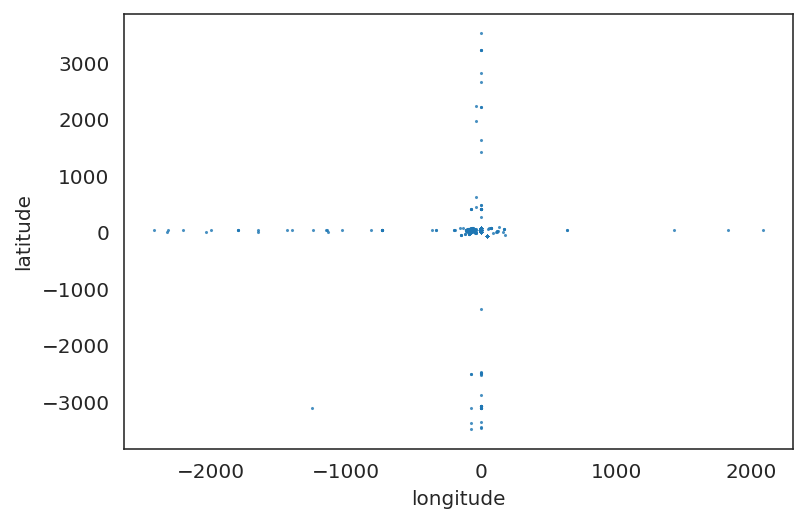

In [ ]:
# Sanity Check Latitude and Longitude Values
longitude = list(trips_df.pickup_longitude) + list(trips_df.dropoff_longitude)
latitude = list(trips_df.pickup_latitude) + list(trips_df.dropoff_latitude)

trip_data = pd.DataFrame({'latitude': latitude, 'longitude': longitude})
sns.set_style("white")
ax = sns.regplot(x="longitude", y="latitude", data=trip_data, scatter=True, fit_reg=False, scatter_kws={"s": 0.3})
plt.show()

In [ ]:
# We have lots of extraneous points here. Let's pare this down to a latitude/longitude range around NYC
longitude_limit = [-74.027, -73.85]
latitude_limit = [40.67, 40.85]
trips_df2 = trips_df.copy()
trips_df2 = trips_df2[(trips_df2.pickup_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
trips_df2 = trips_df2[(trips_df2.dropoff_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
trips_df2 = trips_df2[(trips_df2.pickup_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]
trips_df2 = trips_df2[(trips_df2.dropoff_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]

In [ ]:
# How many trips are 0 secs?
trips_df2[trips_df2.trip_time_in_secs==0].shape[0]

12908

In [ ]:
# How many trips are 0 miles?
trips_df2[trips_df2.trip_distance==0].shape[0]

40234

In [ ]:
trips_df2 = trips_df2[trips_df2.trip_time_in_secs>0]
trips_df2 = trips_df2[trips_df2.trip_distance>0.0]

In [ ]:
trips_df2.passenger_count.value_counts()

1    9403551
2    1799930
5     792559
3     579746
6     545565
4     282996
0          9
8          3
Name: passenger_count, dtype: int64

In [ ]:
# All trips with 1 - 6 passengers
trips_df2 = trips_df2[(trips_df2.passenger_count > 0)&(trips_df2.passenger_count < 7)]
trips_df2.passenger_count.value_counts()

1    9403551
2    1799930
5     792559
3     579746
6     545565
4     282996
Name: passenger_count, dtype: int64

In [ ]:
trips_df2.head()

,index,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,123,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531
1,145,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992
2,3758654,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596
4,3758674,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011
5,3760088,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641


In [ ]:
trips_df2.describe()

,index,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07
mean,7.184094e+06,1.001958e+00,1.724129e+00,7.270489e+02,2.468047e+00,-7.397871e+01,4.075236e+01,-7.397712e+01,4.075252e+01
std,4.154150e+06,1.917688e-01,1.391574e+00,4.846569e+02,2.242401e+00,2.389498e-02,2.307470e-02,2.447654e-02,2.573120e-02
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067000e+01,-7.402699e+01,4.067000e+01
25%,3.589074e+06,1.000000e+00,1.000000e+00,3.700000e+02,1.060000e+00,-7.399270e+01,4.073735e+01,-7.399184e+01,4.073699e+01
50%,7.176393e+06,1.000000e+00,1.000000e+00,6.000000e+02,1.740000e+00,-7.398235e+01,4.075351e+01,-7.398113e+01,4.075403e+01
75%,1.078182e+07,1.000000e+00,2.000000e+00,9.600000e+02,3.000000e+00,-7.396919e+01,4.076785e+01,-7.396682e+01,4.076830e+01
max,1.438546e+07,2.100000e+02,6.000000e+00,1.080000e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01


In [ ]:
trips_df2.shape[0]

13404347

In [ ]:
#trips_df2.to_pickle('gdrive/MyDrive/elula/trips_df2_june.pkl') 

In [ ]:
#import pandas as pd
#trips_df2 = pd.read_pickle('gdrive/MyDrive/elula/trips_df2.pkl')

In [ ]:
trips_df2.head()

,index,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,123,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531
1,145,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992
2,3758654,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596
4,3758674,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011
5,3760088,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641


In [ ]:
query_string2 = '''
                select * from fares order by pickup_datetime asc
'''

In [ ]:
!ls gdrive/MyDrive/elula

fare_data_df.parquet	taxi_df.parquet		trip_fare
fare_data_df.pkl	taxi_df.pkl		trip_fare_4.csv
fare_data_june.parquet	trip_data		trips_df2_june.parquet
fares_df.pkl		trip_data_4.csv		trips_df2.parquet
nyctaxidb.sqlite	trip_data_june.parquet	trips_df2.pkl


In [ ]:
import sqlite3
# Connect to the existing fleetriskdb
con = sqlite3.connect('gdrive/MyDrive/elula/trip_data/nyctaxitripdata2013db.sqlite')
# Confirm data is being returned from this query
fare_data_df = pd.read_sql_query(query_string2, con)
# Verify that result of SQL query is stored in the dataframe
fare_data_df.tail()

In [ ]:
con.close()

In [ ]:
fares_df = fare_data.copy()

In [ ]:
fares_df.shape[0]

14385456

In [ ]:
#fare_data_df.to_pickle('gdrive/MyDrive/elula/fare_data_df.pkl') 

In [ ]:
#import pandas as pd
#fare_data_df = pd.read_pickle('gdrive/MyDrive/elula/fare_data_df.pkl')

In [ ]:
#fare_data_df.to_parquet('gdrive/MyDrive/elula/fare_data_df.parquet')

In [ ]:
import pandas as pd
fare_data_df = pd.read_parquet('gdrive/MyDrive/elula/fare_data_df.parquet')

In [ ]:
fares_df.isnull().sum()

index              0
medallion          0
hack_license       0
vendor_id          0
pickup_datetime    0
payment_type       0
fare_amount        0
surcharge          0
mta_tax            0
tip_amount         0
tolls_amount       0
total_amount       0
dtype: int64

In [ ]:
fares_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14385456 entries, 0 to 14385455
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   index            int64  
 1   medallion        object 
 2   hack_license     object 
 3   vendor_id        object 
 4   pickup_datetime  object 
 5   payment_type     object 
 6   fare_amount      float64
 7   surcharge        float64
 8   mta_tax          float64
 9   tip_amount       float64
 10  tolls_amount     float64
 11  total_amount     float64
dtypes: float64(6), int64(1), object(5)
memory usage: 1.3+ GB


In [ ]:
# Need to look into the $500 fare!
fares_df.describe()

,index,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.438546e+07,1.438546e+07,1.438546e+07,1.438546e+07,1.438546e+07,1.438546e+07,1.438546e+07
mean,7.192728e+06,1.260394e+01,3.176750e-01,4.982277e-01,1.378635e+00,2.618706e-01,1.506042e+01
std,4.152724e+06,1.024164e+01,3.556727e-01,2.971556e-02,2.198706e+00,1.224433e+00,1.228345e+01
min,0.000000e+00,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,3.596364e+06,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,7.192728e+06,9.500000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.140000e+01
75%,1.078909e+07,1.450000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.700000e+01
max,1.438546e+07,5.000000e+02,1.300000e+01,5.000000e-01,2.000000e+02,2.000000e+01,5.655000e+02


In [ ]:
fares_df[fares_df.fare_amount == 500]

,index,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
9418025,13558032,E3E4AA22FF0F3AFF58067D89F08633B4,4669D6DB6D5B6739B9194E999D907924,CMT,2013-06-20 15:33:58,CSH,500.0,0.0,0.0,0.0,0.00,500.00
9424651,13570465,E3E4AA22FF0F3AFF58067D89F08633B4,4669D6DB6D5B6739B9194E999D907924,CMT,2013-06-20 15:52:15,CSH,500.0,0.0,0.0,0.0,0.00,500.00
9428271,13563231,E3E4AA22FF0F3AFF58067D89F08633B4,4669D6DB6D5B6739B9194E999D907924,CMT,2013-06-20 16:03:34,CSH,500.0,0.0,0.0,0.0,0.00,500.00
10379384,13774052,782B8A6E74DE10CD62CECCBE84D5CAB4,E66839CB5F1411C6950AE611135E063F,CMT,2013-06-22 13:38:46,CSH,500.0,0.0,0.0,0.0,10.25,510.25
11057263,13948520,0CDDFF0BFCC418DA6DC6DDEDA5835474,E66839CB5F1411C6950AE611135E063F,CMT,2013-06-23 23:13:58,CSH,500.0,0.0,0.0,0.0,0.00,500.00
11184244,6420943,977D46B58FDD5214D066A0A6EAAE1040,85985C6AFE2F0485FE163147BDE9D2A4,CMT,2013-06-24 10:02:30,CRD,500.0,0.0,0.0,0.0,0.00,500.00
13678423,7800230,782B8A6E74DE10CD62CECCBE84D5CAB4,E66839CB5F1411C6950AE611135E063F,CMT,2013-06-29 12:21:35,CSH,500.0,0.0,0.0,0.0,10.25,510.25
14212905,7178676,E8B6C24CA6EE4ED994B038DCD633B58D,B399C414BBA8A171A0C977DBCD0D61B0,CMT,2013-06-30 14:52:08,CRD,500.0,0.0,0.0,0.0,0.00,500.00
14260865,7167059,7C344021F7C005D4FA2AE29E59470959,9772E134B5729DA6D91C34655F8804B9,CMT,2013-06-30 17:41:30,CRD,500.0,0.0,0.0,0.0,0.00,500.00


In [ ]:
trips_df2.shape

(13404347, 14)

In [ ]:
fares_df.shape

(14385456, 12)


Merge Trips and Fares tables together

In [ ]:
taxi_df = trips_df2.merge(fares_df, on=['medallion','hack_license','vendor_id','pickup_datetime'], how='inner')
taxi_df = taxi_df.drop(['index_x', 'index_y'], axis=1)
taxi_df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531,CRD,10.0,0.5,0.5,2.1,0.0,13.1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992,CSH,9.5,0.5,0.5,0.0,0.0,10.5
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596,CSH,11.0,0.5,0.5,0.0,0.0,12.0
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011,CRD,15.0,0.5,0.5,3.1,0.0,19.1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641,CRD,6.0,0.5,0.5,1.3,0.0,8.3


In [ ]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13404347 entries, 0 to 13404346
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   medallion          object 
 1   hack_license       object 
 2   vendor_id          object 
 3   rate_code          int64  
 4   pickup_datetime    object 
 5   dropoff_datetime   object 
 6   passenger_count    int64  
 7   trip_time_in_secs  int64  
 8   trip_distance      float64
 9   pickup_longitude   float64
 10  pickup_latitude    float64
 11  dropoff_longitude  float64
 12  dropoff_latitude   float64
 13  payment_type       object 
 14  fare_amount        float64
 15  surcharge          float64
 16  mta_tax            float64
 17  tip_amount         float64
 18  tolls_amount       float64
 19  total_amount       float64
dtypes: float64(11), int64(3), object(6)
memory usage: 2.1+ GB


In [ ]:
taxi_df.isnull().sum()

medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
payment_type         0
fare_amount          0
surcharge            0
mta_tax              0
tip_amount           0
tolls_amount         0
total_amount         0
dtype: int64

In [ ]:
taxi_df.shape

(13404347, 20)

In [ ]:
taxi_df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07
mean,1.001958e+00,1.724129e+00,7.270489e+02,2.468047e+00,-7.397871e+01,4.075236e+01,-7.397712e+01,4.075252e+01,1.118458e+01,3.223745e-01,4.998559e-01,1.232379e+00,1.585839e-01,1.339783e+01
std,1.917688e-01,1.391574e+00,4.846569e+02,2.242401e+00,2.389498e-02,2.307470e-02,2.447654e-02,2.573120e-02,6.820675e+00,3.574897e-01,8.487956e-03,1.724917e+00,9.138244e-01,8.329441e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067000e+01,-7.402699e+01,4.067000e+01,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.700000e+02,1.060000e+00,-7.399270e+01,4.073735e+01,-7.399184e+01,4.073699e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.740000e+00,-7.398235e+01,4.075351e+01,-7.398113e+01,4.075403e+01,9.500000e+00,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.100000e+01
75%,1.000000e+00,2.000000e+00,9.600000e+02,3.000000e+00,-7.396919e+01,4.076785e+01,-7.396682e+01,4.076830e+01,1.350000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.600000e+01
max,2.100000e+02,6.000000e+00,1.080000e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01,4.350000e+02,1.050000e+01,5.000000e-01,2.000000e+02,2.000000e+01,5.655000e+02


In [ ]:
taxi_df.to_pickle('gdrive/MyDrive/elula/taxi_df.pkl')

In [ ]:
taxi_df.to_parquet('gdrive/MyDrive/elula/taxi_df_june.parquet')

In [ ]:
taxi_df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07
mean,1.001958e+00,1.724129e+00,7.270489e+02,2.468047e+00,-7.397871e+01,4.075236e+01,-7.397712e+01,4.075252e+01,1.118458e+01,3.223745e-01,4.998559e-01,1.232379e+00,1.585839e-01,1.339783e+01
std,1.917688e-01,1.391574e+00,4.846569e+02,2.242401e+00,2.389498e-02,2.307470e-02,2.447654e-02,2.573120e-02,6.820675e+00,3.574897e-01,8.487956e-03,1.724917e+00,9.138244e-01,8.329441e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067000e+01,-7.402699e+01,4.067000e+01,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.700000e+02,1.060000e+00,-7.399270e+01,4.073735e+01,-7.399184e+01,4.073699e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.740000e+00,-7.398235e+01,4.075351e+01,-7.398113e+01,4.075403e+01,9.500000e+00,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.100000e+01
75%,1.000000e+00,2.000000e+00,9.600000e+02,3.000000e+00,-7.396919e+01,4.076785e+01,-7.396682e+01,4.076830e+01,1.350000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.600000e+01
max,2.100000e+02,6.000000e+00,1.080000e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01,4.350000e+02,1.050000e+01,5.000000e-01,2.000000e+02,2.000000e+01,5.655000e+02


In [ ]:
import pandas as pd
taxi_df = pd.read_parquet('gdrive/MyDrive/elula/taxi_df_june.parquet')

# Exploratory Data Analysis

In [ ]:
taxi_df

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531,CRD,10.0,0.5,0.5,2.1,0.0,13.1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992,CSH,9.5,0.5,0.5,0.0,0.0,10.5
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596,CSH,11.0,0.5,0.5,0.0,0.0,12.0
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011,CRD,15.0,0.5,0.5,3.1,0.0,19.1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641,CRD,6.0,0.5,0.5,1.3,0.0,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,5AC95CB40E97A5B601C68A8E1C85A50D,CMT,1,2013-06-30 23:59:56,2013-07-01 00:02:03,5,126,0.50,-73.979507,40.781570,-73.976067,40.788242,CRD,4.0,0.5,0.5,1.0,0.0,6.0
13404343,B5728C575050CA7ABF88E5617CC6178E,14130B62DB7C3F45904632166988373F,CMT,1,2013-06-30 23:59:56,2013-07-01 00:03:14,1,198,1.00,-73.979767,40.776840,-73.968132,40.767914,CRD,5.0,0.5,0.5,1.0,0.0,7.0
13404344,218ABD31CC8BC45592ECE73989DD630A,FF6E9ABD484E4F236953CB767E417401,CMT,1,2013-06-30 23:59:56,2013-07-01 00:05:43,1,346,1.20,-73.997398,40.718803,-74.009796,40.711235,CSH,6.5,0.5,0.5,0.0,0.0,7.5
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,FC47C36317B37FE32E1BBCA2FA0DBFAF,CMT,1,2013-06-30 23:59:56,2013-07-01 00:10:49,1,653,3.20,-74.006844,40.719715,-73.999565,40.683865,CSH,11.5,0.5,0.5,0.0,0.0,12.5


In [ ]:
taxi_df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07,1.340435e+07
mean,1.001958e+00,1.724129e+00,7.270489e+02,2.468047e+00,-7.397871e+01,4.075236e+01,-7.397712e+01,4.075252e+01,1.118458e+01,3.223745e-01,4.998559e-01,1.232379e+00,1.585839e-01,1.339783e+01
std,1.917688e-01,1.391574e+00,4.846569e+02,2.242401e+00,2.389498e-02,2.307470e-02,2.447654e-02,2.573120e-02,6.820675e+00,3.574897e-01,8.487956e-03,1.724917e+00,9.138244e-01,8.329441e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067000e+01,-7.402699e+01,4.067000e+01,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.700000e+02,1.060000e+00,-7.399270e+01,4.073735e+01,-7.399184e+01,4.073699e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.740000e+00,-7.398235e+01,4.075351e+01,-7.398113e+01,4.075403e+01,9.500000e+00,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.100000e+01
75%,1.000000e+00,2.000000e+00,9.600000e+02,3.000000e+00,-7.396919e+01,4.076785e+01,-7.396682e+01,4.076830e+01,1.350000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.600000e+01
max,2.100000e+02,6.000000e+00,1.080000e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01,4.350000e+02,1.050000e+01,5.000000e-01,2.000000e+02,2.000000e+01,5.655000e+02


In [ ]:
# Max fare amount is $435 - let's investigate
taxi_df[taxi_df.fare_amount == 435]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
2097889,81C4DF9BA06C93EDCC87F6702E0B22F5,51FA34275A96BB8C216F2CBA8A18D0C9,CMT,5,2013-06-05 18:47:55,2013-06-05 18:55:10,1,436,0.1,-73.984421,40.759911,-73.985268,40.759796,CRD,435.0,0.0,0.0,130.5,0.0,565.5


In [ ]:
taxi_df.payment_type.value_counts(normalize=True)

CRD    0.538405
CSH    0.459497
NOC    0.001559
DIS    0.000526
UNK    0.000014
Name: payment_type, dtype: float64

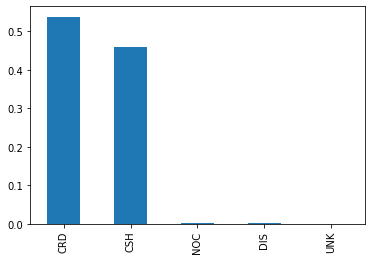

In [ ]:
# Seems like a disputed fare - let's look at different payment types
taxi_df.payment_type.value_counts(normalize=True).plot(kind='bar')
None

In [ ]:
# These other payment types make up a very small portion of our data
# Even though this will slightly bias our results, let's drop No Charge, Disputed or Unknown payment types
taxi_df = taxi_df[(taxi_df.payment_type == 'CRD')|(taxi_df.payment_type == 'CSH')]

In [ ]:
taxi_df.passenger_count.value_counts()

1    9380433
2    1796800
5     792515
3     578594
6     545544
4     282340
Name: passenger_count, dtype: int64

In [ ]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13376226 entries, 0 to 13404346
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   medallion          object 
 1   hack_license       object 
 2   vendor_id          object 
 3   rate_code          int64  
 4   pickup_datetime    object 
 5   dropoff_datetime   object 
 6   passenger_count    int64  
 7   trip_time_in_secs  int64  
 8   trip_distance      float64
 9   pickup_longitude   float64
 10  pickup_latitude    float64
 11  dropoff_longitude  float64
 12  dropoff_latitude   float64
 13  payment_type       object 
 14  fare_amount        float64
 15  surcharge          float64
 16  mta_tax            float64
 17  tip_amount         float64
 18  tolls_amount       float64
 19  total_amount       float64
dtypes: float64(11), int64(3), object(6)
memory usage: 2.1+ GB


In [ ]:
taxi_df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07,1.337623e+07
mean,1.001857e+00,1.725077e+00,7.272162e+02,2.468279e+00,-7.397872e+01,4.075236e+01,-7.397713e+01,4.075253e+01,1.118466e+01,3.223390e-01,4.998674e-01,1.234931e+00,1.585929e-01,1.340045e+01
std,1.912716e-01,1.392539e+00,4.843439e+02,2.241015e+00,2.388848e-02,2.307113e-02,2.446458e-02,2.572508e-02,6.811906e+00,3.575048e-01,8.140971e-03,1.725777e+00,9.136727e-01,8.324072e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067000e+01,-7.402699e+01,4.067000e+01,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.710000e+02,1.060000e+00,-7.399270e+01,4.073736e+01,-7.399184e+01,4.073699e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.740000e+00,-7.398235e+01,4.075351e+01,-7.398113e+01,4.075403e+01,9.500000e+00,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.100000e+01
75%,1.000000e+00,2.000000e+00,9.600000e+02,3.000000e+00,-7.396920e+01,4.076786e+01,-7.396683e+01,4.076830e+01,1.350000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.600000e+01
max,2.100000e+02,6.000000e+00,1.080000e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01,4.350000e+02,1.050000e+01,5.000000e-01,2.000000e+02,2.000000e+01,5.655000e+02


In [ ]:
taxi_df

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531,CRD,10.0,0.5,0.5,2.1,0.0,13.1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992,CSH,9.5,0.5,0.5,0.0,0.0,10.5
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596,CSH,11.0,0.5,0.5,0.0,0.0,12.0
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011,CRD,15.0,0.5,0.5,3.1,0.0,19.1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641,CRD,6.0,0.5,0.5,1.3,0.0,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,5AC95CB40E97A5B601C68A8E1C85A50D,CMT,1,2013-06-30 23:59:56,2013-07-01 00:02:03,5,126,0.50,-73.979507,40.781570,-73.976067,40.788242,CRD,4.0,0.5,0.5,1.0,0.0,6.0
13404343,B5728C575050CA7ABF88E5617CC6178E,14130B62DB7C3F45904632166988373F,CMT,1,2013-06-30 23:59:56,2013-07-01 00:03:14,1,198,1.00,-73.979767,40.776840,-73.968132,40.767914,CRD,5.0,0.5,0.5,1.0,0.0,7.0
13404344,218ABD31CC8BC45592ECE73989DD630A,FF6E9ABD484E4F236953CB767E417401,CMT,1,2013-06-30 23:59:56,2013-07-01 00:05:43,1,346,1.20,-73.997398,40.718803,-74.009796,40.711235,CSH,6.5,0.5,0.5,0.0,0.0,7.5
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,FC47C36317B37FE32E1BBCA2FA0DBFAF,CMT,1,2013-06-30 23:59:56,2013-07-01 00:10:49,1,653,3.20,-74.006844,40.719715,-73.999565,40.683865,CSH,11.5,0.5,0.5,0.0,0.0,12.5


In [ ]:
taxi_df.fare_amount.max()

435.0

In [ ]:
taxi_df.fare_amount.min()

2.5

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


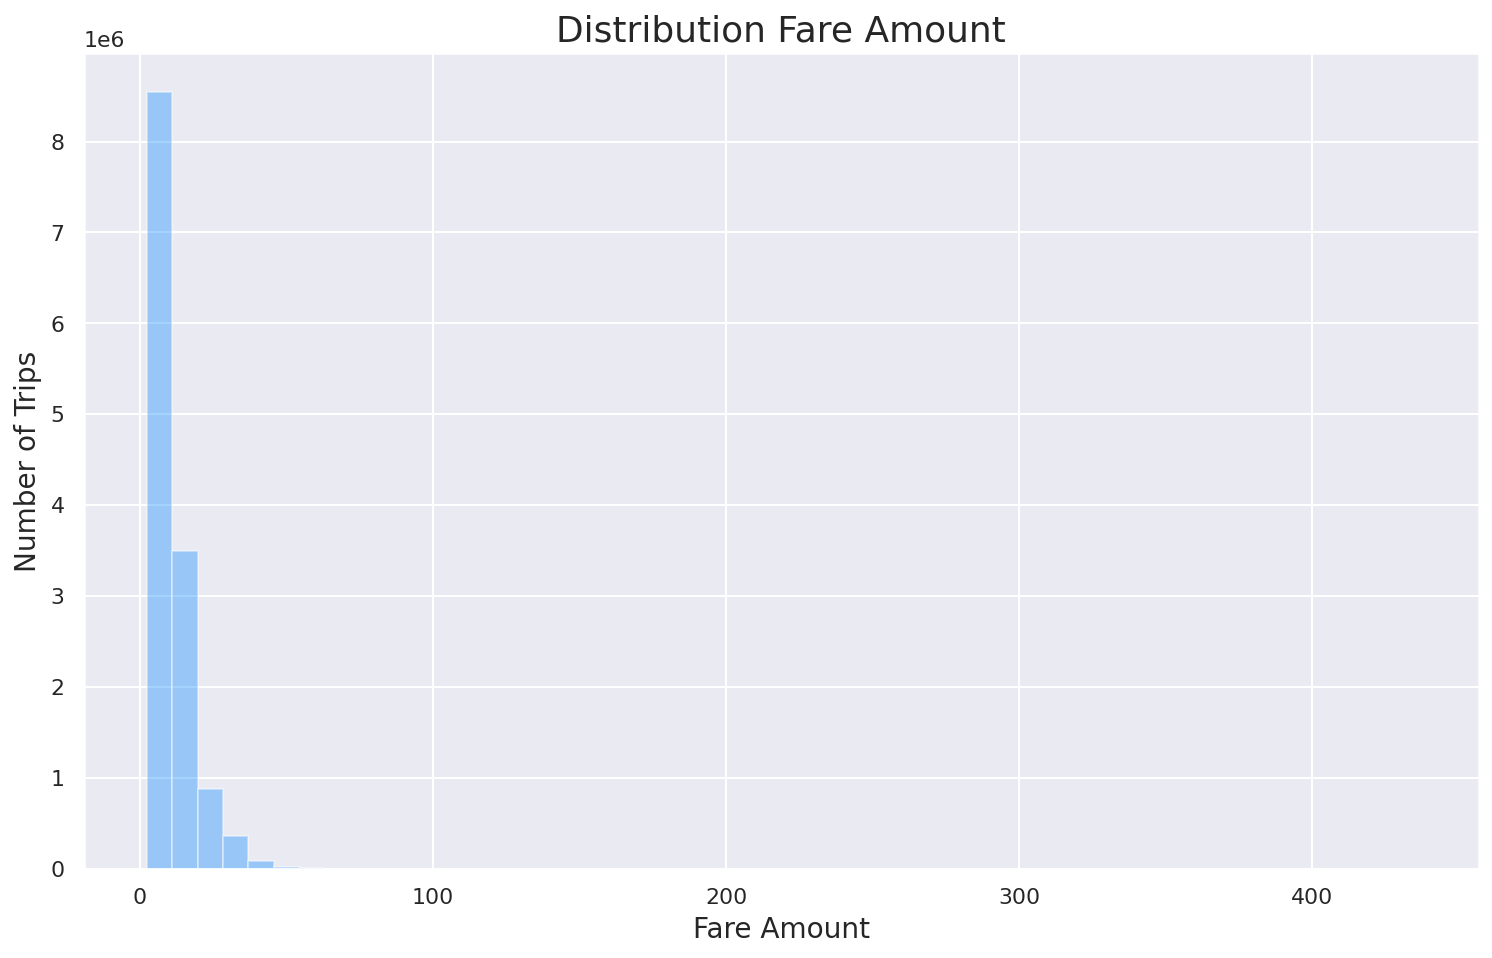

In [ ]:
sns.set_theme(); np.random.seed(0)
(fig, ax) = plt.subplots(figsize=(12.5,7.5))
ax = sns.distplot(taxi_df.fare_amount, kde=False, color="dodgerblue")
ax.set_title('Distribution Fare Amount', fontsize=18)
ax.set_xlabel('Fare Amount', fontsize=14)
ax.set_ylabel('Number of Trips', fontsize=14)
None

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


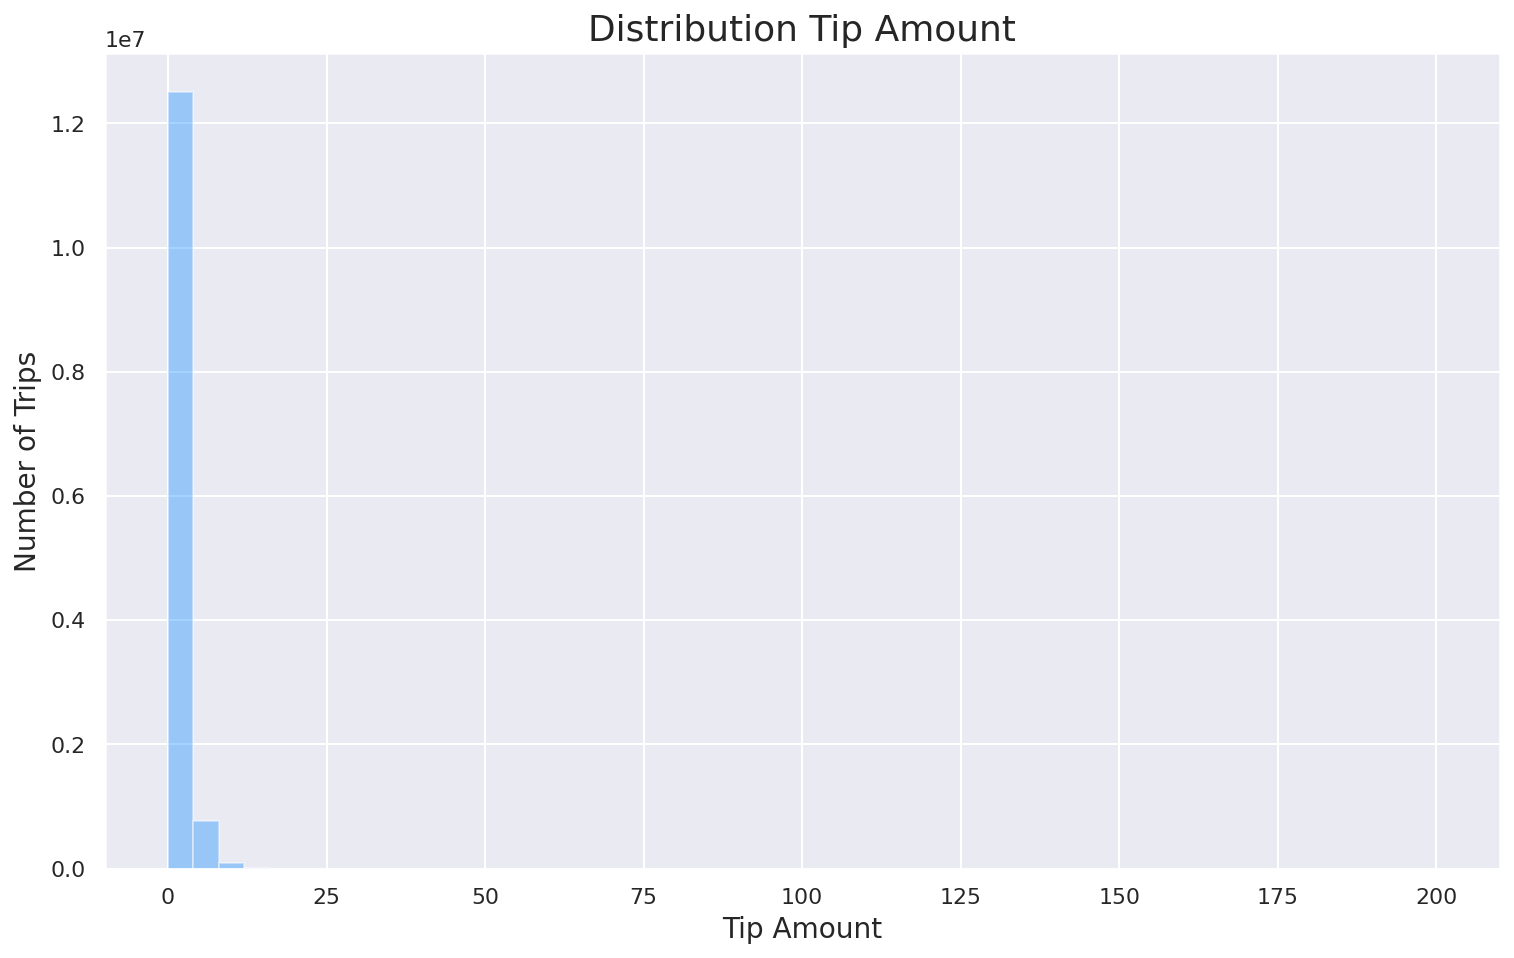

In [ ]:
sns.set_theme(); np.random.seed(0)
(fig, ax) = plt.subplots(figsize=(12.5,7.5))
ax = sns.distplot(taxi_df.tip_amount, kde=False, color="dodgerblue")
ax.set_title('Distribution Tip Amount', fontsize=18)
ax.set_xlabel('Tip Amount', fontsize=14)
ax.set_ylabel('Number of Trips', fontsize=14)
None

In [ ]:
# Plotting function to plot each variable vs variable response (daily average sentiment score)
from matplotlib import pyplot
from pylab import rcParams

def explore_variables(target_name, dt):
    for col in dt.drop(target_name, 1).columns:
        if taxi_df_v.dtypes[taxi_df_v.columns.get_loc(col)] == 'O': # categorical variable
            f, ax = plt.subplots()
            fig = sns.boxplot(x=col, y=target_name, data=dt)
            ax = sns.swarmplot(x=col, y=target_name, data=dt, color=".25", alpha=0.4)
            fig.axis(ymin=0, ymax=50000)
        else: # numerical variable
            fig, ax = pyplot.subplots()
            ax.scatter(x=dt[col], y=dt[target_name])
            pyplot.ylabel(target_name, fontsize=13)
            pyplot.xlabel(col, fontsize=13)
            rcParams['figure.figsize'] = 5, 10
            pyplot.show()

In [ ]:
taxi_df_v = taxi_df[['fare_amount','trip_time_in_secs','trip_distance']]
taxi_df_v

,fare_amount,trip_time_in_secs,trip_distance
0,10.0,660,2.28
1,9.5,600,2.34
2,11.0,780,2.55
3,15.0,960,3.84
4,6.0,300,1.06
...,...,...,...
13404342,4.0,126,0.50
13404343,5.0,198,1.00
13404344,6.5,346,1.20
13404345,11.5,653,3.20


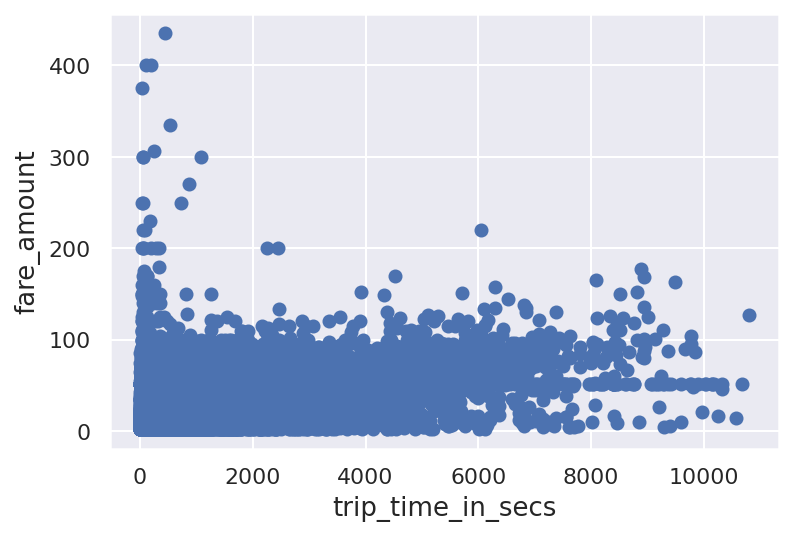

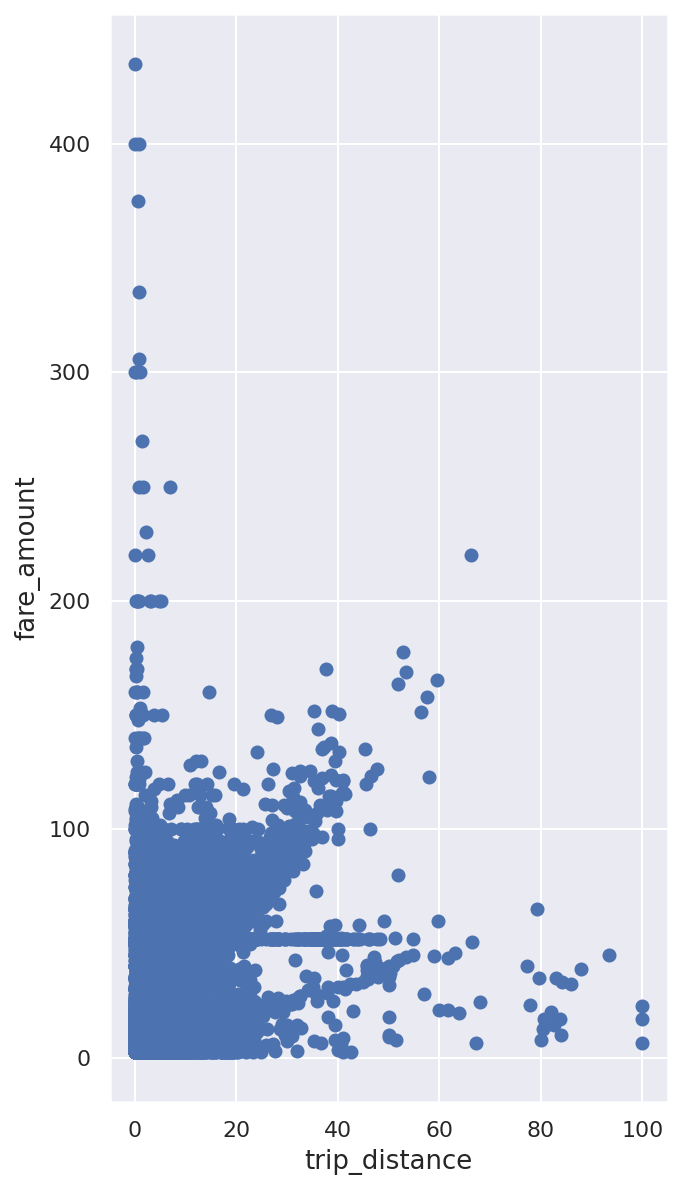

In [ ]:
explore_variables('fare_amount', taxi_df_v)

In [ ]:
#taxi_df.to_parquet('gdrive/MyDrive/elula/taxi_df_june_twopays.parquet')

In [ ]:
import sqlite3
# Create a sqlite3 connection to nyctaxidb
cnxn = sqlite3.connect('nyctaxi_june6_merged.sqlite')

In [ ]:
# Create trips table
taxi_df.to_sql('june6_merged',cnxn)

In [ ]:
cnxn.close()

In [ ]:
import pandas as pd
df = pd.read_parquet('gdrive/MyDrive/elula/taxi_df_june_twopays.parquet')

In [ ]:
df

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531,CRD,10.0,0.5,0.5,2.1,0.0,13.1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992,CSH,9.5,0.5,0.5,0.0,0.0,10.5
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596,CSH,11.0,0.5,0.5,0.0,0.0,12.0
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011,CRD,15.0,0.5,0.5,3.1,0.0,19.1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641,CRD,6.0,0.5,0.5,1.3,0.0,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,5AC95CB40E97A5B601C68A8E1C85A50D,CMT,1,2013-06-30 23:59:56,2013-07-01 00:02:03,5,126,0.50,-73.979507,40.781570,-73.976067,40.788242,CRD,4.0,0.5,0.5,1.0,0.0,6.0
13404343,B5728C575050CA7ABF88E5617CC6178E,14130B62DB7C3F45904632166988373F,CMT,1,2013-06-30 23:59:56,2013-07-01 00:03:14,1,198,1.00,-73.979767,40.776840,-73.968132,40.767914,CRD,5.0,0.5,0.5,1.0,0.0,7.0
13404344,218ABD31CC8BC45592ECE73989DD630A,FF6E9ABD484E4F236953CB767E417401,CMT,1,2013-06-30 23:59:56,2013-07-01 00:05:43,1,346,1.20,-73.997398,40.718803,-74.009796,40.711235,CSH,6.5,0.5,0.5,0.0,0.0,7.5
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,FC47C36317B37FE32E1BBCA2FA0DBFAF,CMT,1,2013-06-30 23:59:56,2013-07-01 00:10:49,1,653,3.20,-74.006844,40.719715,-73.999565,40.683865,CSH,11.5,0.5,0.5,0.0,0.0,12.5


In [ ]:
df['surcharge'].value_counts()

0.00     6638982
0.50     4851398
1.00     1885743
1.50          63
2.00           9
5.00           8
2.50           5
5.50           4
3.00           3
0.70           1
0.10           1
0.60           1
1.20           1
0.52           1
10.50          1
6.66           1
6.50           1
4.00           1
3.50           1
7.50           1
Name: surcharge, dtype: int64

In [ ]:
df['tolls_amount'].value_counts()

0.00     12981326
5.33       389905
10.66        1534
10.25         742
7.50          524
           ...   
5.15            1
5.84            1
7.21            1
9.89            1
10.76           1
Name: tolls_amount, Length: 199, dtype: int64

# Feature **Engineering**

In [ ]:
from datetime import datetime
# Let's codify time of day and day of week
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df['pickup_hour'] = df.pickup_datetime.dt.hour
df.dropoff_datetime = pd.to_datetime(df.dropoff_datetime)
df['dropoff_hour'] = df.dropoff_datetime.dt.hour
# 0 = Monday and 6 = Sunday
df['dayofweek'] = df.pickup_datetime.dt.dayofweek
# Day of Month
df['dayofmonth'] = df.pickup_datetime.dt.day
#taxidf.head()

In [ ]:
taxi_times_pertrip_stats = df.pivot_table(index=['dropoff_hour'], aggfunc= {'trip_time_in_secs':np.mean,'trip_distance':np.mean})

In [ ]:
taxi_times_pertrip_stats

,trip_distance,trip_time_in_secs
dropoff_hour,,
0,2.856469,699.286646
1,2.925670,678.956951
2,2.972321,643.181192
3,3.070315,635.965347
4,3.432483,647.981578
5,3.488183,579.222850
6,2.624644,495.614657
7,2.372356,567.232426
8,2.299191,697.471751


In [ ]:
df_to_driver_occupancy_pivot = df[['hack_license','dayofmonth','dropoff_hour','total_amount']]

In [ ]:
df_to_driver_occupancy_pivot

,hack_license,dayofmonth,dropoff_hour,total_amount
0,24B43BB67CAC5C24A7F92E8F4F8D5F8C,1,0,13.1
1,05F9FB864792A11677F7B1DA051243BA,1,0,10.5
2,2C950F220AFB46EDB83D7D6F0478B32D,1,0,12.0
3,F35F85AE86E972E91567217992F85428,1,0,19.1
4,A4059D3805C1928F0716385C4B88766C,1,0,8.3
...,...,...,...,...
13404342,5AC95CB40E97A5B601C68A8E1C85A50D,30,0,6.0
13404343,14130B62DB7C3F45904632166988373F,30,0,7.0
13404344,FF6E9ABD484E4F236953CB767E417401,30,0,7.5
13404345,FC47C36317B37FE32E1BBCA2FA0DBFAF,30,0,12.5


In [ ]:
df_to_driver_occupancy_pivot["hack_license"] = df_to_driver_occupancy_pivot["hack_license"].astype("category")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_to_driver_occupancy_pivot

,hack_license,dayofmonth,dropoff_hour,total_amount
0,24B43BB67CAC5C24A7F92E8F4F8D5F8C,1,0,13.1
1,05F9FB864792A11677F7B1DA051243BA,1,0,10.5
2,2C950F220AFB46EDB83D7D6F0478B32D,1,0,12.0
3,F35F85AE86E972E91567217992F85428,1,0,19.1
4,A4059D3805C1928F0716385C4B88766C,1,0,8.3
...,...,...,...,...
13404342,5AC95CB40E97A5B601C68A8E1C85A50D,30,0,6.0
13404343,14130B62DB7C3F45904632166988373F,30,0,7.0
13404344,FF6E9ABD484E4F236953CB767E417401,30,0,7.5
13404345,FC47C36317B37FE32E1BBCA2FA0DBFAF,30,0,12.5


In [ ]:
driver_occupancy_pivot = df_to_driver_occupancy_pivot.pivot_table(index=['hack_license'], columns=['dayofmonth','dropoff_hour'], values=['total_amount'])

In [ ]:
driver_occupancy_pivot

total_amount             ...            
dayofmonth                                 1              ...    30      
dropoff_hour                               0          1   ...    22    23
hack_license                                              ...            
0002555BBE359440D6CEB34B699D3932       10.950  15.225000  ...   NaN   NaN
0006C8F9279EFD18D8E70193D98499CB       11.500  15.200000  ...   NaN   8.0
0008B3E338CE8C3377E071A4D80D3694          NaN        NaN  ...   NaN   NaN
000A4EBF1CEB9C6BD9978D4362493C6E       15.000        NaN  ...   NaN   NaN
000B8D660A329BBDBF888500E4BD8B98       18.725  11.500000  ...   NaN   NaN
...                                       ...        ...  ...   ...   ...
FFF657CFEC6A06384C97ACB500916913          NaN        NaN  ...   NaN   NaN
FFF909B1353148850AD3E40BB878618B          NaN        NaN  ...   NaN   NaN
FFFBCEA3D4E21E05902EE67AD556F67C       12.850   9.166667  ...  26.3  14.2
FFFC8985B6B37B60AE71741C01AC423A          NaN        NaN  ...   NaN   NaN
FFFF521546CE00599FF7D09CABC0502B          NaN        NaN  ...   NaN   NaN

[33181 rows x 720 columns]

In [ ]:
driver_occupancy_pivot.to_csv('gdrive/MyDrive/elula/driver_occupancy_pivot.csv')

In [ ]:
import pandas as pd
kmeans_driver = pd.read_csv('gdrive/MyDrive/elula/kmeans_driver.csv')
kmeans_driver

,Driver,Number hours,Amount_of_money
0,0002555BBE359440D6CEB34B699D3932,184.0,3419.484333
1,0006C8F9279EFD18D8E70193D98499CB,169.0,2366.734000
2,0008B3E338CE8C3377E071A4D80D3694,69.0,1448.757500
3,000A4EBF1CEB9C6BD9978D4362493C6E,130.0,1970.691667
4,000B8D660A329BBDBF888500E4BD8B98,203.0,3224.821500
...,...,...,...
33176,FFF657CFEC6A06384C97ACB500916913,94.0,1508.520833
33177,FFF909B1353148850AD3E40BB878618B,170.0,2638.216667
33178,FFFBCEA3D4E21E05902EE67AD556F67C,369.0,4954.161881
33179,FFFC8985B6B37B60AE71741C01AC423A,NaN,NaN


In [ ]:
kmeans_driver.isnull().sum()

Driver             0
Number hours       2
Amount_of_money    2
dtype: int64

In [ ]:
kmeans_driver.dropna(inplace=True)

In [ ]:

kmeans_driver

,Driver,Number hours,Amount_of_money
0,0002555BBE359440D6CEB34B699D3932,184.0,3419.484333
1,0006C8F9279EFD18D8E70193D98499CB,169.0,2366.734000
2,0008B3E338CE8C3377E071A4D80D3694,69.0,1448.757500
3,000A4EBF1CEB9C6BD9978D4362493C6E,130.0,1970.691667
4,000B8D660A329BBDBF888500E4BD8B98,203.0,3224.821500
...,...,...,...
33174,FFF0D1CE8F65C1A8B213128325EB5F33,218.0,3260.661000
33175,FFF5AD65C673251C1F275CF5B43EC414,336.0,4546.868333
33176,FFF657CFEC6A06384C97ACB500916913,94.0,1508.520833
33177,FFF909B1353148850AD3E40BB878618B,170.0,2638.216667


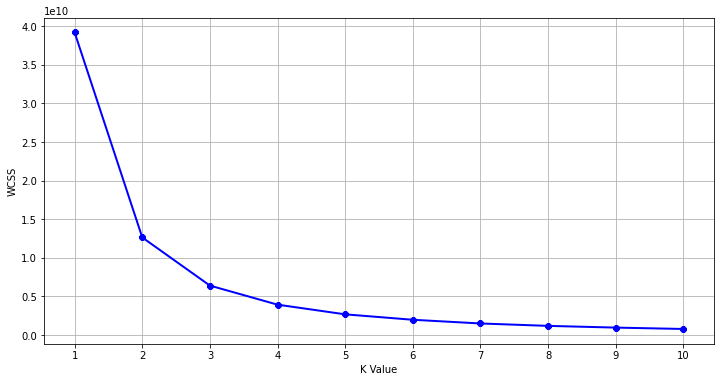

In [ ]:
#from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
from sklearn.cluster import KMeans
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(kmeans_driver.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="blue", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [ ]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(kmeans_driver.iloc[:,1:])
kmeans_driver["label"] = clusters



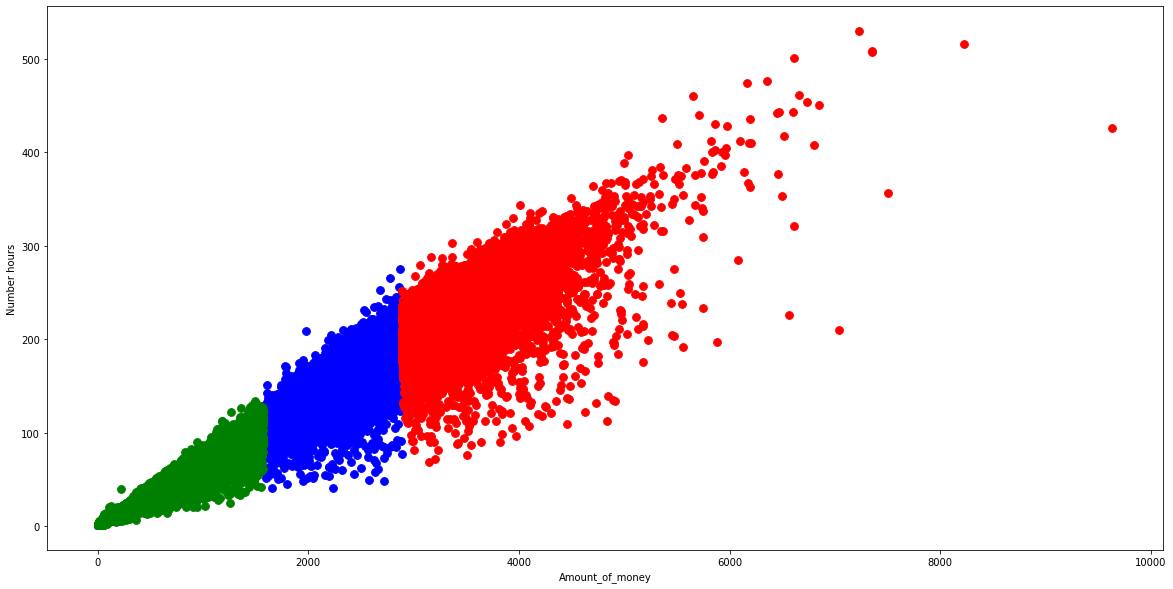

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.scatter(kmeans_driver.Amount_of_money[kmeans_driver.label == 0], kmeans_driver["Number hours"][kmeans_driver.label == 0], c='blue', s=60)
ax.scatter(kmeans_driver.Amount_of_money[kmeans_driver.label == 1], kmeans_driver["Number hours"][kmeans_driver.label == 1], c='red', s=60)
ax.scatter(kmeans_driver.Amount_of_money[kmeans_driver.label == 2], kmeans_driver["Number hours"][kmeans_driver.label == 2], c='green', s=60)
plt.xlabel("Amount_of_money")
plt.ylabel("Number hours")
plt.show()

In [ ]:
df

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531,CRD,10.0,0.5,0.5,2.1,0.0,13.1,0,0,5,1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992,CSH,9.5,0.5,0.5,0.0,0.0,10.5,0,0,5,1
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596,CSH,11.0,0.5,0.5,0.0,0.0,12.0,0,0,5,1
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011,CRD,15.0,0.5,0.5,3.1,0.0,19.1,0,0,5,1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641,CRD,6.0,0.5,0.5,1.3,0.0,8.3,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,5AC95CB40E97A5B601C68A8E1C85A50D,CMT,1,2013-06-30 23:59:56,2013-07-01 00:02:03,5,126,0.50,-73.979507,40.781570,-73.976067,40.788242,CRD,4.0,0.5,0.5,1.0,0.0,6.0,23,0,6,30
13404343,B5728C575050CA7ABF88E5617CC6178E,14130B62DB7C3F45904632166988373F,CMT,1,2013-06-30 23:59:56,2013-07-01 00:03:14,1,198,1.00,-73.979767,40.776840,-73.968132,40.767914,CRD,5.0,0.5,0.5,1.0,0.0,7.0,23,0,6,30
13404344,218ABD31CC8BC45592ECE73989DD630A,FF6E9ABD484E4F236953CB767E417401,CMT,1,2013-06-30 23:59:56,2013-07-01 00:05:43,1,346,1.20,-73.997398,40.718803,-74.009796,40.711235,CSH,6.5,0.5,0.5,0.0,0.0,7.5,23,0,6,30
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,FC47C36317B37FE32E1BBCA2FA0DBFAF,CMT,1,2013-06-30 23:59:56,2013-07-01 00:10:49,1,653,3.20,-74.006844,40.719715,-73.999565,40.683865,CSH,11.5,0.5,0.5,0.0,0.0,12.5,23,0,6,30


In [ ]:
query_string3 = '''
                select * from june_merged order by pickup_datetime asc
'''

In [ ]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('nyctaxi_june6_merged.sqlite')
# Confirm data is being returned from this query
df = pd.read_sql_query(query_string3, con)
df

,index,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.60,0.0,15.60
1,1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.00,0.0,35.00
2,2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.10,0.0,7.10
3,3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01 00:00:00,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.00,0.0,10.50
4,4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01 00:00:00,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.50,0.0,9.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14064063,14100154,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.00,-73.981850,40.783993,-73.991020,40.770947,CSH,5.5,0.5,0.5,0.00,0.0,6.50
14064064,14100155,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.20,-73.976997,40.761559,-74.003853,40.742271,CRD,14.5,0.5,0.5,2.00,0.0,17.50
14064065,14100156,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.60,-73.979881,40.776081,-73.982071,40.768272,CRD,4.0,0.5,0.5,1.00,0.0,6.00
14064066,14100157,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.70,-73.942482,40.779572,-73.942482,40.779572,CRD,7.5,0.5,0.5,1.11,0.0,9.61


In [ ]:
## Verify that result of SQL query is stored in the dataframe
#df = df.drop('index', axis=1)
# Let's filter down to Rate codes 1, 2 and 3 - NYC and its surrounding airports.


In [ ]:
taxidf = df.copy()
#taxidf = taxidf[taxidf.rate_code < 4]
taxidf

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531,CRD,10.0,0.5,0.5,2.1,0.0,13.1,0,0,5,1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992,CSH,9.5,0.5,0.5,0.0,0.0,10.5,0,0,5,1
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596,CSH,11.0,0.5,0.5,0.0,0.0,12.0,0,0,5,1
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011,CRD,15.0,0.5,0.5,3.1,0.0,19.1,0,0,5,1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641,CRD,6.0,0.5,0.5,1.3,0.0,8.3,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,5AC95CB40E97A5B601C68A8E1C85A50D,CMT,1,2013-06-30 23:59:56,2013-07-01 00:02:03,5,126,0.50,-73.979507,40.781570,-73.976067,40.788242,CRD,4.0,0.5,0.5,1.0,0.0,6.0,23,0,6,30
13404343,B5728C575050CA7ABF88E5617CC6178E,14130B62DB7C3F45904632166988373F,CMT,1,2013-06-30 23:59:56,2013-07-01 00:03:14,1,198,1.00,-73.979767,40.776840,-73.968132,40.767914,CRD,5.0,0.5,0.5,1.0,0.0,7.0,23,0,6,30
13404344,218ABD31CC8BC45592ECE73989DD630A,FF6E9ABD484E4F236953CB767E417401,CMT,1,2013-06-30 23:59:56,2013-07-01 00:05:43,1,346,1.20,-73.997398,40.718803,-74.009796,40.711235,CSH,6.5,0.5,0.5,0.0,0.0,7.5,23,0,6,30
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,FC47C36317B37FE32E1BBCA2FA0DBFAF,CMT,1,2013-06-30 23:59:56,2013-07-01 00:10:49,1,653,3.20,-74.006844,40.719715,-73.999565,40.683865,CSH,11.5,0.5,0.5,0.0,0.0,12.5,23,0,6,30


In [ ]:
taxidf[taxidf.trip_distance < 0].shape[0]

0

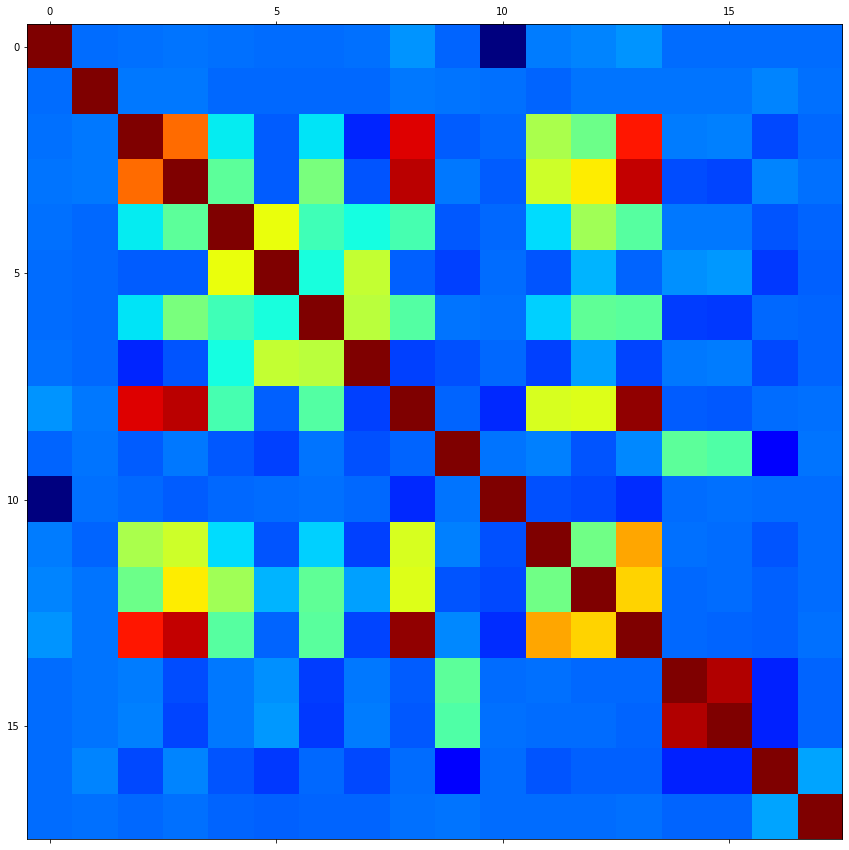

In [ ]:
import seaborn as sns
import matplotlib.cm as cm
taxidf_corrmat = taxidf.corr()
fig, ax = plt.subplots(figsize=(28,15))
ax.matshow(taxidf_corrmat,cmap=cm.jet)
plt.style.use('classic')
#plt.xticks(range(len(taxidf_corrmat.columns)), taxidf_corrmat.columns)   # draw x tick marks
#plt.yticks(range(len(taxidf_corrmat.columns)), taxidf_corrmat.columns) 
#ax = sns.heatmap(taxidf_corrmat, annot = True)

In [ ]:
taxidf_corrmat

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth
rate_code,1.000000,-0.000466,0.005158,0.012074,0.004027,-0.000607,-0.000627,0.003196,0.051763,-0.008372,-0.302455,0.020511,0.031452,0.049409,-0.001562,-0.001767,-0.000242,-0.001913
passenger_count,-0.000466,1.000000,0.014857,0.015867,-0.002680,-0.005194,-0.003245,-0.003631,0.013157,0.009200,0.003541,-0.012074,0.008549,0.009604,0.011852,0.010348,0.028888,0.003720
trip_time_in_secs,0.005158,0.014857,1.000000,0.733661,0.162619,-0.019192,0.153451,-0.089456,0.890470,-0.020621,-0.004797,0.421995,0.325694,0.851057,0.023096,0.025557,-0.043011,-0.003413
trip_distance,0.012074,0.015867,0.733661,1.000000,0.302644,-0.017551,0.347308,-0.028601,0.929489,0.014072,-0.017564,0.480804,0.552725,0.921576,-0.042944,-0.050654,0.030912,0.004387
pickup_longitude,0.004027,-0.002680,0.162619,0.302644,1.000000,0.522060,0.254803,0.187716,0.265938,-0.027138,-0.002585,0.145078,0.404756,0.290965,0.014615,0.017237,-0.031768,-0.012136
pickup_latitude,-0.000607,-0.005194,-0.019192,-0.017551,0.522060,1.000000,0.195885,0.464023,-0.016320,-0.056258,0.000512,-0.028228,0.089767,-0.011770,0.046475,0.054407,-0.066158,-0.013201
dropoff_longitude,-0.000627,-0.003245,0.153451,0.347308,0.254803,0.195885,1.000000,0.446007,0.284555,0.010221,0.004626,0.128459,0.305488,0.293471,-0.063239,-0.065353,-0.005664,-0.008408
dropoff_latitude,0.003196,-0.003631,-0.089456,-0.028601,0.187716,0.464023,0.446007,1.000000,-0.053157,-0.033352,-0.005776,-0.056702,0.064947,-0.049565,0.014666,0.022414,-0.044320,-0.009458
fare_amount,0.051763,0.013157,0.890470,0.929489,0.265938,-0.016320,0.284555,-0.053157,1.000000,-0.011144,-0.088606,0.495984,0.505802,0.976123,-0.022020,-0.025172,-0.000791,0.003125
surcharge,-0.008372,0.009200,-0.020621,0.014072,-0.027138,-0.056258,0.010221,-0.033352,-0.011144,1.000000,0.012148,0.025030,-0.030872,0.035640,0.301546,0.281125,-0.147237,0.009971


In [ ]:
taxidf

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531,CRD,10.0,0.5,0.5,2.1,0.0,13.1,0,0,5,1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992,CSH,9.5,0.5,0.5,0.0,0.0,10.5,0,0,5,1
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596,CSH,11.0,0.5,0.5,0.0,0.0,12.0,0,0,5,1
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011,CRD,15.0,0.5,0.5,3.1,0.0,19.1,0,0,5,1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641,CRD,6.0,0.5,0.5,1.3,0.0,8.3,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,5AC95CB40E97A5B601C68A8E1C85A50D,CMT,1,2013-06-30 23:59:56,2013-07-01 00:02:03,5,126,0.50,-73.979507,40.781570,-73.976067,40.788242,CRD,4.0,0.5,0.5,1.0,0.0,6.0,23,0,6,30
13404343,B5728C575050CA7ABF88E5617CC6178E,14130B62DB7C3F45904632166988373F,CMT,1,2013-06-30 23:59:56,2013-07-01 00:03:14,1,198,1.00,-73.979767,40.776840,-73.968132,40.767914,CRD,5.0,0.5,0.5,1.0,0.0,7.0,23,0,6,30
13404344,218ABD31CC8BC45592ECE73989DD630A,FF6E9ABD484E4F236953CB767E417401,CMT,1,2013-06-30 23:59:56,2013-07-01 00:05:43,1,346,1.20,-73.997398,40.718803,-74.009796,40.711235,CSH,6.5,0.5,0.5,0.0,0.0,7.5,23,0,6,30
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,FC47C36317B37FE32E1BBCA2FA0DBFAF,CMT,1,2013-06-30 23:59:56,2013-07-01 00:10:49,1,653,3.20,-74.006844,40.719715,-73.999565,40.683865,CSH,11.5,0.5,0.5,0.0,0.0,12.5,23,0,6,30


# Modeling 

In [ ]:
features = df[['pickup_longitude','pickup_latitude',
                      'dropoff_longitude','dropoff_latitude','trip_distance','pickup_hour',
                      'dropoff_hour','dayofweek','dayofmonth']]
target = df.fare_amount
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.33, random_state=9)

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg_mod = LinearRegression()

In [ ]:
lin_reg_mod.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lin_reg_mod.predict(X_test)

In [ ]:
pred

array([10.67250715, 12.09473707, 21.96993874, ...,  6.68572557,
        4.33861427, 14.99643345])

In [ ]:
from sklearn.metrics import mean_squared_error
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))

In [ ]:
print(test_set_rmse)

2.484679326742233


In [ ]:
from sklearn.metrics import r2_score
test_set_r2 = r2_score(y_test, pred)

In [ ]:
print(test_set_r2)

0.8666307061109568


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
ridge_regressor.best_params_

{'alpha': 0.0001}

In [ ]:
ridge_regressor.best_score_

-6.137587155954508

In [ ]:
rr = Ridge(alpha=0.0001)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

2.477394383948392
0.8678899955312753
2.484679326722689
0.8666307061130549


In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)

lasso_regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20667912.520685524, tolerance: 33303.76466894159
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16988610.469644718, tolerance: 33320.081256973855
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16558496.87019546, tolerance: 33357.88589520465
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20796708.

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
lasso_regressor.best_params_

{'alpha': 1e-08}

In [ ]:
lasso_regressor.best_score_

-6.1375871559354165

In [ ]:
model_lasso = Lasso(alpha=0.0001)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

2.4774229588472445
0.8678869479327092
2.484686842264599
0.86662989929342


In [ ]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
DecisionTreeRegModel = DecisionTreeRegressor(random_state = 0)  
  
# fit the regressor with X and Y data 
DecisionTreeRegModel.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
y_pred = DecisionTreeRegModel.predict(X_test)
y_pred

array([10. , 12.5, 18.5, ...,  6. ,  6. , 17. ])

In [ ]:
r2_score(y_test, y_pred)

0.8520047932378527

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mse

6.850661216472917

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

2.617376781526289

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
# load data
# split data into X and y
X = X_train 
y = y_train
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

[20:50:35] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
r2_score(y_test, y_pred)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mse

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

In [ ]:
import xgboost as xg 
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123) 
  
# Fitting the model 
xgb_r.fit(X_train, y_train) 
  
# Predict the model 
pred = xgb_r.predict(X_test) 
  
# RMSE Computation 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

#rmse = np.sqrt(MSE(test_y, pred)) 
print("RMSE : % f" %(rmse))

In [ ]:
features_tip = df[['pickup_longitude','pickup_latitude',
                      'dropoff_longitude','dropoff_latitude','trip_distance','pickup_hour',
                      'dropoff_hour','dayofweek','dayofmonth']]
target_tip = df.tip_amount
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_tip, target_tip, test_size = 0.33, random_state=9)

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg_mod = LinearRegression()

In [ ]:
lin_reg_mod.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred = lin_reg_mod.predict(X_test)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))

In [ ]:
print(test_set_rmse)

1.5084620928879158


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
test_set_r2 = r2_score(y_test, pred)

In [ ]:
print(test_set_r2)

0.23596312776419714


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alpha = [1e-15, 1e-10, 1e-8, 1e-4]

ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4]}

ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
ridge_regressor.best_params_

{'alpha': 0.0001}

In [ ]:
ridge_regressor.best_score_

-2.2733372258844837

In [ ]:
rr = Ridge(alpha=0.0001)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

1.5077552202137388
0.23671728062603103
1.5084620928889474
0.2359631277631521


In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)

lasso_regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5371994.616530083, tolerance: 2139.6326592007235
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295090.6280948287, tolerance: 2134.2141349625754
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5187915.458829924, tolerance: 2135.3973797400304
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80288.51

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
lasso_regressor.best_params_

{'alpha': 1e-15}

In [ ]:
lasso_regressor.best_score_

-2.2733372258846796

In [ ]:
model_lasso = Lasso(alpha=0.0001)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

1.5077888009861724
0.23668328053318788
1.5085051776311753
0.23591948224901504


In [ ]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
DecisionTreeRegModel = DecisionTreeRegressor(random_state = 0)  
  
# fit the regressor with X and Y data 
DecisionTreeRegModel.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
y_pred = DecisionTreeRegModel.predict(X_test)

In [ ]:
r2_score(y_test, y_pred)

-0.4804067270934136

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mse

4.408953656019986

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

2.0997508557016915

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
# load data
# split data into X and y
X = X
y = Y
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [ ]:
import xgboost as xg 
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123) 
  
# Fitting the model 
xgb_r.fit(X_train, y_train) 
  
# Predict the model 
pred = xgb_r.predict(X_test) 
  
# RMSE Computation 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

#rmse = np.sqrt(MSE(test_y, pred)) 
print("RMSE : % f" %(rmse))

[21:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:36:23] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
RMSE :  2.099751


In [ ]:
import numpy as np
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
X_train.shape

(8962071, 9)

In [ ]:
# Create a neural network function to pass it on to the Keras Regressor
def build_neural_network():
    model = Sequential()
    model.add(Dense(10, input_dim=9, kernel_initializer='random_normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='random_normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
model = KerasRegressor(build_fn=build_neural_network, epochs=300, verbose=0)
X=X_train
Y=y_train
results = cross_val_score(estimator=model, X=np.array(X), y=np.array(Y), cv=10)
print("Using a Neural Network the Mean Square Error of airport fares is %.2f (%.2f)" % (results.mean(), results.std()))

In [ ]:
from datetime import datetime
# Let's codify time of day and day of week
taxidf.pickup_datetime = pd.to_datetime(taxidf.pickup_datetime)
taxidf['pickup_hour'] = taxidf.pickup_datetime.dt.hour
taxidf.dropoff_datetime = pd.to_datetime(taxidf.dropoff_datetime)
taxidf['dropoff_hour'] = taxidf.dropoff_datetime.dt.hour
# 0 = Monday and 6 = Sunday
taxidf['dayofweek'] = taxidf.pickup_datetime.dt.dayofweek
# Day of Month
taxidf['dayofmonth'] = taxidf.pickup_datetime.dt.day
#taxidf.head()

In [ ]:
taxidf

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531,CRD,10.0,0.5,0.5,2.1,0.0,13.1,0,0,5,1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992,CSH,9.5,0.5,0.5,0.0,0.0,10.5,0,0,5,1
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596,CSH,11.0,0.5,0.5,0.0,0.0,12.0,0,0,5,1
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011,CRD,15.0,0.5,0.5,3.1,0.0,19.1,0,0,5,1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641,CRD,6.0,0.5,0.5,1.3,0.0,8.3,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,5AC95CB40E97A5B601C68A8E1C85A50D,CMT,1,2013-06-30 23:59:56,2013-07-01 00:02:03,5,126,0.50,-73.979507,40.781570,-73.976067,40.788242,CRD,4.0,0.5,0.5,1.0,0.0,6.0,23,0,6,30
13404343,B5728C575050CA7ABF88E5617CC6178E,14130B62DB7C3F45904632166988373F,CMT,1,2013-06-30 23:59:56,2013-07-01 00:03:14,1,198,1.00,-73.979767,40.776840,-73.968132,40.767914,CRD,5.0,0.5,0.5,1.0,0.0,7.0,23,0,6,30
13404344,218ABD31CC8BC45592ECE73989DD630A,FF6E9ABD484E4F236953CB767E417401,CMT,1,2013-06-30 23:59:56,2013-07-01 00:05:43,1,346,1.20,-73.997398,40.718803,-74.009796,40.711235,CSH,6.5,0.5,0.5,0.0,0.0,7.5,23,0,6,30
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,FC47C36317B37FE32E1BBCA2FA0DBFAF,CMT,1,2013-06-30 23:59:56,2013-07-01 00:10:49,1,653,3.20,-74.006844,40.719715,-73.999565,40.683865,CSH,11.5,0.5,0.5,0.0,0.0,12.5,23,0,6,30


In [ ]:
taxidf['medallion'].value_counts()

A4FC84D2662D988828DBD26B0948A413    2057
20BA941F62CC07F1FA3EF3E122B1E9B2    1922
F6D6BAD72F4E5BAE1E2BD2A366ADAAED    1837
171FD91CBF0D6FABF499A9452A4950D5    1836
75EE5A7E8B24FD2B2FB715955834C524    1813
                                    ... 
752B268CEBA3DE5F005E3330850DF4AE       3
74999DFDD58D58EBDF6C6DA7ED8058F1       1
D56D09471F4D358A25A0C7B0F71C9B22       1
668DBA6E00E3E279FCA5C235F2C93FDB       1
F8EFEF0452B221DFFD8CBCEAD8A6925B       1
Name: medallion, Length: 13359, dtype: int64

In [ ]:
taxidf['hack_license'].value_counts()

3D757E111C78F5CAC83D44A92885D490    1459
23F5E8FB4BC7E65E825E8484A596C45C    1442
51C1BE97280A80EBFA8DAD34E1956CF6    1362
0C71F8127769E79E88C06D5FFFE6B0B8    1356
9E035DBF346FDE01FE87FAB470276DA6    1341
                                    ... 
410DF05A10FE9591B00B82DAD73EEAE3       1
7029A498C4F596F73B35504DF9BAB02A       1
AC39FCF9DDBF6623420E441FC3E13596       1
F5039343412F7A1AF7905D71BA979A77       1
1271E3A3EF72FBA2FDAF3E32D015A36E       1
Name: hack_license, Length: 33181, dtype: int64

In [ ]:
# 2 d.p. of precision will suffice
taxi_ = taxidf.copy()
taxi_['pickup_latitude'] = taxidf.pickup_latitude.round(2)
taxi_['pickup_longitude'] = taxidf.pickup_longitude.round(2)
taxi_['dropoff_latitude'] = taxidf.dropoff_latitude.round(2)
taxi_['dropoff_longitude'] = taxidf.dropoff_longitude.round(2)
taxi_.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01,2013-06-01 00:11:00,1,660,2.28,-74.01,40.72,-73.98,40.73,CRD,10.0,0.5,0.5,2.1,0.0,13.1,0,0,5,1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01,2013-06-01 00:10:00,1,600,2.34,-73.99,40.73,-73.99,40.75,CSH,9.5,0.5,0.5,0.0,0.0,10.5,0,0,5,1
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01,2013-06-01 00:13:00,5,780,2.55,-73.99,40.73,-73.98,40.76,CSH,11.0,0.5,0.5,0.0,0.0,12.0,0,0,5,1
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01,2013-06-01 00:16:00,1,960,3.84,-74.00,40.73,-73.98,40.68,CRD,15.0,0.5,0.5,3.1,0.0,19.1,0,0,5,1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01,2013-06-01 00:05:00,6,300,1.06,-74.01,40.74,-73.99,40.75,CRD,6.0,0.5,0.5,1.3,0.0,8.3,0,0,5,1


In [ ]:
taxi_['pickup_geocode'] = taxi_.pickup_latitude.astype(str) + ', ' + taxi_.pickup_longitude.astype(str)
taxi_['dropoff_geocode'] = taxi_.dropoff_latitude.astype(str) + ', ' + taxi_.dropoff_longitude.astype(str)
taxi_.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth,pickup_geocode,dropoff_geocode
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01,2013-06-01 00:11:00,1,660,2.28,-74.01,40.72,-73.98,40.73,CRD,10.0,0.5,0.5,2.1,0.0,13.1,0,0,5,1,"40.72, -74.01","40.73, -73.98"
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01,2013-06-01 00:10:00,1,600,2.34,-73.99,40.73,-73.99,40.75,CSH,9.5,0.5,0.5,0.0,0.0,10.5,0,0,5,1,"40.73, -73.99","40.75, -73.99"
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01,2013-06-01 00:13:00,5,780,2.55,-73.99,40.73,-73.98,40.76,CSH,11.0,0.5,0.5,0.0,0.0,12.0,0,0,5,1,"40.73, -73.99","40.76, -73.98"
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01,2013-06-01 00:16:00,1,960,3.84,-74.00,40.73,-73.98,40.68,CRD,15.0,0.5,0.5,3.1,0.0,19.1,0,0,5,1,"40.73, -74.0","40.68, -73.98"
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01,2013-06-01 00:05:00,6,300,1.06,-74.01,40.74,-73.99,40.75,CRD,6.0,0.5,0.5,1.3,0.0,8.3,0,0,5,1,"40.74, -74.01","40.75, -73.99"


In [ ]:
pickup = taxi_.groupby('pickup_geocode')['pickup_geocode'].count().sort_values(ascending=False)


In [ ]:
#Top10
pickup = taxi_.groupby('pickup_geocode')['pickup_geocode'].count().sort_values(ascending=False).head(10)

In [ ]:
pickup

pickup_geocode
40.76, -73.97    824410
40.75, -73.99    766107
40.75, -73.98    678524
40.76, -73.98    664531
40.76, -73.99    619971
                  ...  
40.81, -73.87         1
40.8, -74.03          1
40.68, -74.03         1
40.78, -73.85         1
40.85, -74.03         1
Name: pickup_geocode, Length: 355, dtype: int64

In [ ]:
pickup = pickup.to_frame().rename(columns={'pickup_geocode':'Number of Trips'}).reset_index()

In [ ]:
pickup

,pickup_geocode,Number of Trips
0,"40.76, -73.97",824410
1,"40.75, -73.99",766107
2,"40.75, -73.98",678524
3,"40.76, -73.98",664531
4,"40.76, -73.99",619971
...,...,...
350,"40.81, -73.87",1
351,"40.8, -74.03",1
352,"40.68, -74.03",1
353,"40.78, -73.85",1


In [ ]:
pickup.to_csv('gdrive/MyDrive/elula/355pickups.csv')

In [ ]:
pickup.to_csv('gdrive/MyDrive/elula/top10pickups.csv')

In [ ]:
print(pickup[pickup['pickup_geocode'].isnull()])

Empty DataFrame
Columns: [pickup_geocode, Number of Trips]
Index: []


In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")
pickup_df = pickup.copy()
pickup_df = pickup_df.rename(columns={'pickup_geocode':'Pickup_Geocode'})
pickup_df['location'] = pickup_df.Pickup_Geocode.apply(geolocator.reverse)
pickup_df['address'] = [i.address for i in pickup_df.location]
pickup_df['address'] = pickup_df['address'].astype(str)
pickup_df['zipcode'] = pickup_df['address'].str.extract('(\d{5})', expand=True)
pickup_df.drop('location',axis=1,inplace=True)
pickup_df

,Pickup_Geocode,Number of Trips,address,zipcode
0,"40.76, -73.97",824410,"664, Lexington Avenue, Midtown East, Manhattan...",10022
1,"40.75, -73.99",766107,"137, West 33rd Street, Herald Square, Manhatta...",10001
2,"40.75, -73.98",678524,"35, East 38th Street, Murray Hill, Manhattan C...",10016
3,"40.76, -73.98",664531,"Rockefeller Center, 45, Rockefeller Plaza, Mid...",10111
4,"40.76, -73.99",619971,"341, West 45th Street, Theater District, Times...",10036
...,...,...,...,...
350,"40.81, -73.87",1,"400, Food Center Drive, The Bronx, Bronx Count...",10474
351,"40.8, -74.03",1,"West Side Avenue, New Durham, North Bergen, Hu...",07047
352,"40.68, -74.03",1,"Kings County, New York, United States",NaN
353,"40.78, -73.85",1,"Arrow Yacht Club, 22nd Avenue, Queens, Queens ...",11356


In [ ]:
pickup_df.to_csv('gdrive/MyDrive/elula/355pickups.csv')

In [ ]:
pickup_df.to_csv('gdrive/MyDrive/elula/pickup355_df_adressess_zipcode.csv')

In [ ]:
taxi_car_occupancy = taxidf.copy()

In [ ]:
taxi_car_occupancy

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531,CRD,10.0,0.5,0.5,2.1,0.0,13.1,0,0,5,1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992,CSH,9.5,0.5,0.5,0.0,0.0,10.5,0,0,5,1
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596,CSH,11.0,0.5,0.5,0.0,0.0,12.0,0,0,5,1
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011,CRD,15.0,0.5,0.5,3.1,0.0,19.1,0,0,5,1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641,CRD,6.0,0.5,0.5,1.3,0.0,8.3,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,5AC95CB40E97A5B601C68A8E1C85A50D,CMT,1,2013-06-30 23:59:56,2013-07-01 00:02:03,5,126,0.50,-73.979507,40.781570,-73.976067,40.788242,CRD,4.0,0.5,0.5,1.0,0.0,6.0,23,0,6,30
13404343,B5728C575050CA7ABF88E5617CC6178E,14130B62DB7C3F45904632166988373F,CMT,1,2013-06-30 23:59:56,2013-07-01 00:03:14,1,198,1.00,-73.979767,40.776840,-73.968132,40.767914,CRD,5.0,0.5,0.5,1.0,0.0,7.0,23,0,6,30
13404344,218ABD31CC8BC45592ECE73989DD630A,FF6E9ABD484E4F236953CB767E417401,CMT,1,2013-06-30 23:59:56,2013-07-01 00:05:43,1,346,1.20,-73.997398,40.718803,-74.009796,40.711235,CSH,6.5,0.5,0.5,0.0,0.0,7.5,23,0,6,30
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,FC47C36317B37FE32E1BBCA2FA0DBFAF,CMT,1,2013-06-30 23:59:56,2013-07-01 00:10:49,1,653,3.20,-74.006844,40.719715,-73.999565,40.683865,CSH,11.5,0.5,0.5,0.0,0.0,12.5,23,0,6,30


In [ ]:
taxi_car_occupancy_datetimes = taxi_car_occupancy[['pickup_datetime','dropoff_datetime']]
taxi_car_occupancy_datetimes 

,pickup_datetime,dropoff_datetime
0,2013-06-01 00:00:00,2013-06-01 00:11:00
1,2013-06-01 00:00:00,2013-06-01 00:10:00
2,2013-06-01 00:00:00,2013-06-01 00:13:00
3,2013-06-01 00:00:00,2013-06-01 00:16:00
4,2013-06-01 00:00:00,2013-06-01 00:05:00
...,...,...
13404342,2013-06-30 23:59:56,2013-07-01 00:02:03
13404343,2013-06-30 23:59:56,2013-07-01 00:03:14
13404344,2013-06-30 23:59:56,2013-07-01 00:05:43
13404345,2013-06-30 23:59:56,2013-07-01 00:10:49


In [ ]:
import numpy as np
import pandas as pd
import datetime

# ---- Create df sample
df = taxi_car_occupancy_datetimes 
df['start'] = pd.to_datetime(df['pickup_datetime'])
df['end'] = pd.to_datetime(df['dropoff_datetime'])

# ---- Create day index
temp_day = datetime.date(2013,6,1)
index = [(temp_day + datetime.timedelta(hours=d)) for d in range(720)]

# ---- Create empty result df
# initialize df, set days as datetime in index
d = pd.DataFrame(np.zeros((720,2)),
                 index=pd.to_datetime(index),
                 columns=['occupancy','occupied_day'])

# ---- Iterate over df to fill d (final df)
for i, row in df.iterrows():
    print('i',i)
    print('row',row)
    # Add 1 if first day for new visitor
    #d.loc[row.start,'new_visitor'] += 1
    # 1 if some visitor in df.start, df.end
    d.loc[row.start:row.end,'occupied_day'] = 1
    # Add 1 for visitor occupancy these days
    d.loc[row.start:row.end,'occupancy'] += 1

#cumulated days = some of occupied days
d['cumul_days'] = d.occupied_day.cumsum()
#cumulated visitors = some of occupancy
d['cumul_visitors'] = d.occupancy.cumsum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Streaming output truncated to the last 5000 lines.
end                2013-07-01 00:19:49
Name: 13403509, dtype: datetime64[ns]
i 13403510
row pickup_datetime    2013-06-30 23:55:53
dropoff_datetime   2013-07-01 00:00:16
start              2013-06-30 23:55:53
end                2013-07-01 00:00:16
Name: 13403510, dtype: datetime64[ns]
i 13403511
row pickup_datetime    2013-06-30 23:55:53
dropoff_datetime   2013-07-01 00:00:01
start              2013-06-30 23:55:53
end                2013-07-01 00:00:01
Name: 13403511, dtype: datetime64[ns]
i 13403512
row pickup_datetime    2013-06-30 23:55:53
dropoff_datetime   2013-07-01 00:06:11
start              2013-06-30 23:55:53
end                2013-07-01 00:06:11
Name: 13403512, dtype: datetime64[ns]
i 13403513
row pickup_datetime    2013-06-30 23:55:54
dropoff_datetime   2013-07-01 00:00:22
start              2013-06-30 23:55:54
end                2013-07-01 00:00:22
Name: 13403513, dtype: datetime64[ns]
i 13403514
row pickup_datetime    20

In [ ]:
d.to_csv('gdrive/MyDrive/elula/d.csv')

In [ ]:
d

,occupancy,occupied_day,cumul_days,cumul_visitors
2013-06-01,263.0,1.0,1.0,263.0
2013-06-01,263.0,1.0,2.0,526.0
2013-06-01,263.0,1.0,3.0,789.0
2013-06-01,263.0,1.0,4.0,1052.0
2013-06-01,263.0,1.0,5.0,1315.0
...,...,...,...,...
2013-06-30,5999.0,1.0,716.0,3069844.0
2013-06-30,5999.0,1.0,717.0,3075843.0
2013-06-30,5999.0,1.0,718.0,3081842.0
2013-06-30,5999.0,1.0,719.0,3087841.0


In [ ]:
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2021-03-21


In [ ]:
taxi_car_occupancy_pivot = taxi_car_occupancy.pivot_table(index=['medallion'], columns=['dayofmonth','dropoff_hour'], aggfunc='count', fill_value=0,margins=True)


In [ ]:
taxi_car_occupancy_pivot

dayofweek                 ... vendor_id               
dayofmonth                              1                  ...        30               
dropoff_hour                            0  1  2  3  4  5   ...        18 19 20 21 22 23
medallion                                                  ...                         
00005007A9F30E289E760362F69E4EAD         3  4  3  2  3  0  ...         2  0  1  2  0  0
000318C2E3E6381580E5C99910A60668         0  0  0  0  0  0  ...         0  0  0  3  2  5
000351EDC735C079246435340A54C7C1         4  3  3  3  0  0  ...         2  2  5  3  1  3
0009986BDBAB2F9A125FEF49D0BFCCDD         3  3  4  3  0  0  ...         0  1  3  3  4  3
00115F46520039845A5F719C979BEA45         1  2  5  2  0  0  ...         0  0  0  1  4  4
...                                    ... .. .. .. .. ..  ...       ... .. .. .. .. ..
FFEE0D464EEA83AF6EA50CA5738B5610         0  0  0  0  0  0  ...         0  0  0  0  0  0
FFEF5E9BA26FC9B6B5F2CF433833572D         0  0  0  0  0  0  ...         1  0  3  3  2  5
FFF010F904EF7B60DAF12560AFE5127C         0  0  0  0  0  0  ...         2  2  2  2  2  4
FFF9D2834D24079962E68642F14BAC82         4  2  5  2  0  0  ...         0  4  0  0  2  2
FFFECF75AB6CC4FF9E8A8B633AB81C26         1  2  0  0  0  0  ...         0  0  0  0  0  0

[13359 rows x 15120 columns]

In [ ]:
taxi_car_occupancy_pivot.to_csv('gdrive/MyDrive/elula/taxi_car_occupancy_pivot.csv')

In [ ]:
taxi_car_occupancy_pivot.describe()

dayofweek                ...     vendor_id              
dayofmonth              1                 ...            30              
dropoff_hour            0             1   ...            22            23
count         13359.000000  13359.000000  ...  13359.000000  13359.000000
mean              2.097088      1.829703  ...      1.355191      1.185717
std               1.587425      1.528919  ...      1.580064      1.455746
min               0.000000      0.000000  ...      0.000000      0.000000
25%               1.000000      0.000000  ...      0.000000      0.000000
50%               2.000000      2.000000  ...      1.000000      0.000000
75%               3.000000      3.000000  ...      3.000000      2.000000
max               8.000000      8.000000  ...      7.000000      7.000000

[8 rows x 15120 columns]

In [ ]:
taxi_tableau

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,24B43BB67CAC5C24A7F92E8F4F8D5F8C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:11:00,1,660,2.28,-74.007370,40.719189,-73.983261,40.727531,CRD,10.0,0.5,0.5,2.1,0.0,13.1,0,0,5,1
1,34A6D6B37688CD29D53017C130F658E4,05F9FB864792A11677F7B1DA051243BA,VTS,1,2013-06-01 00:00:00,2013-06-01 00:10:00,1,600,2.34,-73.992043,40.725639,-73.990120,40.750992,CSH,9.5,0.5,0.5,0.0,0.0,10.5,0,0,5,1
2,33E72FD3FB448499AAB5672CA571CE09,2C950F220AFB46EDB83D7D6F0478B32D,VTS,1,2013-06-01 00:00:00,2013-06-01 00:13:00,5,780,2.55,-73.994202,40.726742,-73.982132,40.755596,CSH,11.0,0.5,0.5,0.0,0.0,12.0,0,0,5,1
3,E3FB99712D99954D259002EBAF4AD015,F35F85AE86E972E91567217992F85428,VTS,1,2013-06-01 00:00:00,2013-06-01 00:16:00,1,960,3.84,-73.999619,40.728466,-73.977432,40.681011,CRD,15.0,0.5,0.5,3.1,0.0,19.1,0,0,5,1
4,550DE61F56D157D38E1C96E23FA9997B,A4059D3805C1928F0716385C4B88766C,VTS,1,2013-06-01 00:00:00,2013-06-01 00:05:00,6,300,1.06,-74.006813,40.744080,-73.994583,40.750641,CRD,6.0,0.5,0.5,1.3,0.0,8.3,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,5AC95CB40E97A5B601C68A8E1C85A50D,CMT,1,2013-06-30 23:59:56,2013-07-01 00:02:03,5,126,0.50,-73.979507,40.781570,-73.976067,40.788242,CRD,4.0,0.5,0.5,1.0,0.0,6.0,23,0,6,30
13404343,B5728C575050CA7ABF88E5617CC6178E,14130B62DB7C3F45904632166988373F,CMT,1,2013-06-30 23:59:56,2013-07-01 00:03:14,1,198,1.00,-73.979767,40.776840,-73.968132,40.767914,CRD,5.0,0.5,0.5,1.0,0.0,7.0,23,0,6,30
13404344,218ABD31CC8BC45592ECE73989DD630A,FF6E9ABD484E4F236953CB767E417401,CMT,1,2013-06-30 23:59:56,2013-07-01 00:05:43,1,346,1.20,-73.997398,40.718803,-74.009796,40.711235,CSH,6.5,0.5,0.5,0.0,0.0,7.5,23,0,6,30
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,FC47C36317B37FE32E1BBCA2FA0DBFAF,CMT,1,2013-06-30 23:59:56,2013-07-01 00:10:49,1,653,3.20,-74.006844,40.719715,-73.999565,40.683865,CSH,11.5,0.5,0.5,0.0,0.0,12.5,23,0,6,30


In [ ]:
taxi_tableau.drop(["hack_license", "vendor_id", "dropoff_datetime", "dropoff_longitude", "dropoff_latitude", "payment_type"], inplace=True, axis=1)

In [ ]:
taxi_tableau

,medallion,rate_code,pickup_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dayofweek
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,1,2013-06-01 00:00:00,1,660,2.28,-74.007370,40.719189,10.0,0.5,0.5,2.1,0.0,13.1,0,5
1,34A6D6B37688CD29D53017C130F658E4,1,2013-06-01 00:00:00,1,600,2.34,-73.992043,40.725639,9.5,0.5,0.5,0.0,0.0,10.5,0,5
2,33E72FD3FB448499AAB5672CA571CE09,1,2013-06-01 00:00:00,5,780,2.55,-73.994202,40.726742,11.0,0.5,0.5,0.0,0.0,12.0,0,5
3,E3FB99712D99954D259002EBAF4AD015,1,2013-06-01 00:00:00,1,960,3.84,-73.999619,40.728466,15.0,0.5,0.5,3.1,0.0,19.1,0,5
4,550DE61F56D157D38E1C96E23FA9997B,1,2013-06-01 00:00:00,6,300,1.06,-74.006813,40.744080,6.0,0.5,0.5,1.3,0.0,8.3,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,1,2013-06-30 23:59:56,5,126,0.50,-73.979507,40.781570,4.0,0.5,0.5,1.0,0.0,6.0,23,6
13404343,B5728C575050CA7ABF88E5617CC6178E,1,2013-06-30 23:59:56,1,198,1.00,-73.979767,40.776840,5.0,0.5,0.5,1.0,0.0,7.0,23,6
13404344,218ABD31CC8BC45592ECE73989DD630A,1,2013-06-30 23:59:56,1,346,1.20,-73.997398,40.718803,6.5,0.5,0.5,0.0,0.0,7.5,23,6
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,1,2013-06-30 23:59:56,1,653,3.20,-74.006844,40.719715,11.5,0.5,0.5,0.0,0.0,12.5,23,6


In [ ]:
# 2 d.p. of precision will suffice
taxi_vis = taxi_tableau.copy()
taxi_vis['pickup_latitude'] = taxi_vis.pickup_latitude.round(2)
taxi_vis['pickup_longitude'] = taxi_vis.pickup_longitude.round(2)
taxi_vis.head()

,medallion,rate_code,pickup_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dayofweek
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,1,2013-06-01,1,660,2.28,-74.01,40.72,10.0,0.5,0.5,2.1,0.0,13.1,0,5
1,34A6D6B37688CD29D53017C130F658E4,1,2013-06-01,1,600,2.34,-73.99,40.73,9.5,0.5,0.5,0.0,0.0,10.5,0,5
2,33E72FD3FB448499AAB5672CA571CE09,1,2013-06-01,5,780,2.55,-73.99,40.73,11.0,0.5,0.5,0.0,0.0,12.0,0,5
3,E3FB99712D99954D259002EBAF4AD015,1,2013-06-01,1,960,3.84,-74.00,40.73,15.0,0.5,0.5,3.1,0.0,19.1,0,5
4,550DE61F56D157D38E1C96E23FA9997B,1,2013-06-01,6,300,1.06,-74.01,40.74,6.0,0.5,0.5,1.3,0.0,8.3,0,5


In [ ]:
taxi_vis['pickup_geocode'] = taxi_vis.pickup_latitude.astype(str) + ', ' + taxi_vis.pickup_longitude.astype(str)

In [ ]:
taxi_vis

,medallion,rate_code,pickup_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dayofweek,pickup_geocode
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,1,2013-06-01 00:00:00,1,660,2.28,-74.01,40.72,10.0,0.5,0.5,2.1,0.0,13.1,0,5,"40.72, -74.01"
1,34A6D6B37688CD29D53017C130F658E4,1,2013-06-01 00:00:00,1,600,2.34,-73.99,40.73,9.5,0.5,0.5,0.0,0.0,10.5,0,5,"40.73, -73.99"
2,33E72FD3FB448499AAB5672CA571CE09,1,2013-06-01 00:00:00,5,780,2.55,-73.99,40.73,11.0,0.5,0.5,0.0,0.0,12.0,0,5,"40.73, -73.99"
3,E3FB99712D99954D259002EBAF4AD015,1,2013-06-01 00:00:00,1,960,3.84,-74.00,40.73,15.0,0.5,0.5,3.1,0.0,19.1,0,5,"40.73, -74.0"
4,550DE61F56D157D38E1C96E23FA9997B,1,2013-06-01 00:00:00,6,300,1.06,-74.01,40.74,6.0,0.5,0.5,1.3,0.0,8.3,0,5,"40.74, -74.01"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,1,2013-06-30 23:59:56,5,126,0.50,-73.98,40.78,4.0,0.5,0.5,1.0,0.0,6.0,23,6,"40.78, -73.98"
13404343,B5728C575050CA7ABF88E5617CC6178E,1,2013-06-30 23:59:56,1,198,1.00,-73.98,40.78,5.0,0.5,0.5,1.0,0.0,7.0,23,6,"40.78, -73.98"
13404344,218ABD31CC8BC45592ECE73989DD630A,1,2013-06-30 23:59:56,1,346,1.20,-74.00,40.72,6.5,0.5,0.5,0.0,0.0,7.5,23,6,"40.72, -74.0"
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,1,2013-06-30 23:59:56,1,653,3.20,-74.01,40.72,11.5,0.5,0.5,0.0,0.0,12.5,23,6,"40.72, -74.01"


In [ ]:
taxi_vis = taxi_vis.rename(columns={'pickup_geocode': 'Pickup_Geocode'})
taxi_vis

,medallion,rate_code,pickup_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dayofweek,Pickup_Geocode
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,1,2013-06-01 00:00:00,1,660,2.28,-74.01,40.72,10.0,0.5,0.5,2.1,0.0,13.1,0,5,"40.72, -74.01"
1,34A6D6B37688CD29D53017C130F658E4,1,2013-06-01 00:00:00,1,600,2.34,-73.99,40.73,9.5,0.5,0.5,0.0,0.0,10.5,0,5,"40.73, -73.99"
2,33E72FD3FB448499AAB5672CA571CE09,1,2013-06-01 00:00:00,5,780,2.55,-73.99,40.73,11.0,0.5,0.5,0.0,0.0,12.0,0,5,"40.73, -73.99"
3,E3FB99712D99954D259002EBAF4AD015,1,2013-06-01 00:00:00,1,960,3.84,-74.00,40.73,15.0,0.5,0.5,3.1,0.0,19.1,0,5,"40.73, -74.0"
4,550DE61F56D157D38E1C96E23FA9997B,1,2013-06-01 00:00:00,6,300,1.06,-74.01,40.74,6.0,0.5,0.5,1.3,0.0,8.3,0,5,"40.74, -74.01"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404342,11EE001B196E490E914A3BF4A2223150,1,2013-06-30 23:59:56,5,126,0.50,-73.98,40.78,4.0,0.5,0.5,1.0,0.0,6.0,23,6,"40.78, -73.98"
13404343,B5728C575050CA7ABF88E5617CC6178E,1,2013-06-30 23:59:56,1,198,1.00,-73.98,40.78,5.0,0.5,0.5,1.0,0.0,7.0,23,6,"40.78, -73.98"
13404344,218ABD31CC8BC45592ECE73989DD630A,1,2013-06-30 23:59:56,1,346,1.20,-74.00,40.72,6.5,0.5,0.5,0.0,0.0,7.5,23,6,"40.72, -74.0"
13404345,6F4220AA54EE75B0D11B55AD2B6922C1,1,2013-06-30 23:59:56,1,653,3.20,-74.01,40.72,11.5,0.5,0.5,0.0,0.0,12.5,23,6,"40.72, -74.01"


In [ ]:
taxi_vis_df = taxi_vis.merge(pickup_df, on=['Pickup_Geocode'])
taxi_vis_df

,medallion,rate_code,pickup_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dayofweek,Pickup_Geocode,Number of Trips,address,zipcode
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,1,2013-06-01 00:00:00,1,660,2.28,-74.01,40.72,10.0,0.5,0.5,2.10,0.0,13.10,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
1,8EC82124F974FC1FD2EECA55DECBDBAD,1,2013-06-01 00:00:00,1,540,3.01,-74.01,40.72,10.5,0.5,0.5,2.00,0.0,13.50,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
2,BA5E4104F2476174ED8534EB698D4B7B,1,2013-06-01 00:00:00,1,1320,4.56,-74.01,40.72,18.5,0.5,0.5,4.75,0.0,24.25,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
3,25C8A610A492CB515974C2EA5D47ABD8,1,2013-06-01 00:00:00,2,540,1.05,-74.01,40.72,7.0,0.5,0.5,1.50,0.0,9.50,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
4,67108EDF8123623806A1DAFE8811EE63,1,2013-06-01 00:00:00,5,60,0.46,-74.01,40.72,3.5,0.5,0.5,0.00,0.0,4.50,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13376221,DDB3F3E0172B1FBF0C9E39CA773CC6E3,1,2013-06-25 20:01:53,1,897,2.00,-73.99,40.85,11.5,0.5,0.5,2.50,0.0,15.00,20,1,"40.85, -73.99",3,"509, Glen Avenue, Koreatown, Palisades Park, B...",07650
13376222,DDB3F3E0172B1FBF0C9E39CA773CC6E3,1,2013-06-25 22:27:31,1,565,1.30,-73.99,40.85,8.0,0.5,0.5,1.80,0.0,10.80,22,1,"40.85, -73.99",3,"509, Glen Avenue, Koreatown, Palisades Park, B...",07650
13376223,302EB02F36343A64C452D49463A27C88,1,2013-06-27 19:47:14,1,1202,2.30,-73.96,40.85,13.5,1.0,0.5,3.00,0.0,18.00,19,3,"40.85, -73.96",1,"Henry Hudson Drive, Linwood, Fort Lee, Bergen ...",07024
13376224,66E4F52E591854BB56D4EF5EC1C65B37,1,2013-06-28 12:55:00,1,1500,1.25,-73.85,40.78,15.0,0.0,0.5,0.00,0.0,15.50,12,4,"40.78, -73.85",1,"Arrow Yacht Club, 22nd Avenue, Queens, Queens ...",11356


In [ ]:
taxi_vis_df

,medallion,rate_code,pickup_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dayofweek,Pickup_Geocode,Number of Trips,address,zipcode
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,1,2013-06-01 00:00:00,1,660,2.28,-74.01,40.72,10.0,0.5,0.5,2.10,0.0,13.10,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
1,8EC82124F974FC1FD2EECA55DECBDBAD,1,2013-06-01 00:00:00,1,540,3.01,-74.01,40.72,10.5,0.5,0.5,2.00,0.0,13.50,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
2,BA5E4104F2476174ED8534EB698D4B7B,1,2013-06-01 00:00:00,1,1320,4.56,-74.01,40.72,18.5,0.5,0.5,4.75,0.0,24.25,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
3,25C8A610A492CB515974C2EA5D47ABD8,1,2013-06-01 00:00:00,2,540,1.05,-74.01,40.72,7.0,0.5,0.5,1.50,0.0,9.50,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
4,67108EDF8123623806A1DAFE8811EE63,1,2013-06-01 00:00:00,5,60,0.46,-74.01,40.72,3.5,0.5,0.5,0.00,0.0,4.50,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13376221,DDB3F3E0172B1FBF0C9E39CA773CC6E3,1,2013-06-25 20:01:53,1,897,2.00,-73.99,40.85,11.5,0.5,0.5,2.50,0.0,15.00,20,1,"40.85, -73.99",3,"509, Glen Avenue, Koreatown, Palisades Park, B...",07650
13376222,DDB3F3E0172B1FBF0C9E39CA773CC6E3,1,2013-06-25 22:27:31,1,565,1.30,-73.99,40.85,8.0,0.5,0.5,1.80,0.0,10.80,22,1,"40.85, -73.99",3,"509, Glen Avenue, Koreatown, Palisades Park, B...",07650
13376223,302EB02F36343A64C452D49463A27C88,1,2013-06-27 19:47:14,1,1202,2.30,-73.96,40.85,13.5,1.0,0.5,3.00,0.0,18.00,19,3,"40.85, -73.96",1,"Henry Hudson Drive, Linwood, Fort Lee, Bergen ...",07024
13376224,66E4F52E591854BB56D4EF5EC1C65B37,1,2013-06-28 12:55:00,1,1500,1.25,-73.85,40.78,15.0,0.0,0.5,0.00,0.0,15.50,12,4,"40.78, -73.85",1,"Arrow Yacht Club, 22nd Avenue, Queens, Queens ...",11356


In [ ]:
print(taxi_vis_df[taxi_vis_df['zipcode'].isnull()])

                                 medallion  ...  zipcode
3521290   7DF16486AECCFB7DB3DA7A33B2DF62D4  ...      NaN
3521291   13E378597424D0A82D2DE84D2070D0C7  ...      NaN
3521292   FD26FB5E970C62255F9F66EC70DD5DC9  ...      NaN
3521293   07A0A68365AC8905157956356A804271  ...      NaN
3521294   6652CE5ACEF5E414C6FFEA71A8DB86F3  ...      NaN
...                                    ...  ...      ...
12411745  E2CA172EF73EA8DEB8429113111271B9  ...      NaN
12411746  85278944CDB91980FA465FF4D4667A5A  ...      NaN
12411747  171BF6AD2C32D927735A7A5ADB516512  ...      NaN
12411748  E36F8DD6FA78327F52EF9E258678664F  ...      NaN
13376225  66E4F52E591854BB56D4EF5EC1C65B37  ...      NaN

[384038 rows x 20 columns]


In [ ]:
taxi_vis_df.dropna(inplace=True)
taxi_vis_df

,medallion,rate_code,pickup_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dayofweek,Pickup_Geocode,Number of Trips,address,zipcode
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,1,2013-06-01 00:00:00,1,660,2.28,-74.01,40.72,10.0,0.5,0.5,2.10,0.0,13.10,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
1,8EC82124F974FC1FD2EECA55DECBDBAD,1,2013-06-01 00:00:00,1,540,3.01,-74.01,40.72,10.5,0.5,0.5,2.00,0.0,13.50,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
2,BA5E4104F2476174ED8534EB698D4B7B,1,2013-06-01 00:00:00,1,1320,4.56,-74.01,40.72,18.5,0.5,0.5,4.75,0.0,24.25,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
3,25C8A610A492CB515974C2EA5D47ABD8,1,2013-06-01 00:00:00,2,540,1.05,-74.01,40.72,7.0,0.5,0.5,1.50,0.0,9.50,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
4,67108EDF8123623806A1DAFE8811EE63,1,2013-06-01 00:00:00,5,60,0.46,-74.01,40.72,3.5,0.5,0.5,0.00,0.0,4.50,0,5,"40.72, -74.01",209788,"68, North Moore Street, Tribeca, Manhattan Com...",10013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13376220,DDB3F3E0172B1FBF0C9E39CA773CC6E3,1,2013-06-25 19:51:59,1,362,1.10,-73.99,40.85,6.0,1.0,0.5,0.00,0.0,7.50,19,1,"40.85, -73.99",3,"509, Glen Avenue, Koreatown, Palisades Park, B...",07650
13376221,DDB3F3E0172B1FBF0C9E39CA773CC6E3,1,2013-06-25 20:01:53,1,897,2.00,-73.99,40.85,11.5,0.5,0.5,2.50,0.0,15.00,20,1,"40.85, -73.99",3,"509, Glen Avenue, Koreatown, Palisades Park, B...",07650
13376222,DDB3F3E0172B1FBF0C9E39CA773CC6E3,1,2013-06-25 22:27:31,1,565,1.30,-73.99,40.85,8.0,0.5,0.5,1.80,0.0,10.80,22,1,"40.85, -73.99",3,"509, Glen Avenue, Koreatown, Palisades Park, B...",07650
13376223,302EB02F36343A64C452D49463A27C88,1,2013-06-27 19:47:14,1,1202,2.30,-73.96,40.85,13.5,1.0,0.5,3.00,0.0,18.00,19,3,"40.85, -73.96",1,"Henry Hudson Drive, Linwood, Fort Lee, Bergen ...",07024


In [ ]:
taxi_vis_df.drop(['Number of Trips'], inplace=True, axis=1)
taxi_vis_df

,medallion,rate_code,pickup_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dayofweek,Pickup_Geocode,address,zipcode
0,CBD2B4AD574EE83E3869F2EF1E8F37A2,1,2013-06-01 00:00:00,1,660,2.28,-74.01,40.72,10.0,0.5,0.5,2.10,0.0,13.10,0,5,"40.72, -74.01","68, North Moore Street, Tribeca, Manhattan Com...",10013
1,8EC82124F974FC1FD2EECA55DECBDBAD,1,2013-06-01 00:00:00,1,540,3.01,-74.01,40.72,10.5,0.5,0.5,2.00,0.0,13.50,0,5,"40.72, -74.01","68, North Moore Street, Tribeca, Manhattan Com...",10013
2,BA5E4104F2476174ED8534EB698D4B7B,1,2013-06-01 00:00:00,1,1320,4.56,-74.01,40.72,18.5,0.5,0.5,4.75,0.0,24.25,0,5,"40.72, -74.01","68, North Moore Street, Tribeca, Manhattan Com...",10013
3,25C8A610A492CB515974C2EA5D47ABD8,1,2013-06-01 00:00:00,2,540,1.05,-74.01,40.72,7.0,0.5,0.5,1.50,0.0,9.50,0,5,"40.72, -74.01","68, North Moore Street, Tribeca, Manhattan Com...",10013
4,67108EDF8123623806A1DAFE8811EE63,1,2013-06-01 00:00:00,5,60,0.46,-74.01,40.72,3.5,0.5,0.5,0.00,0.0,4.50,0,5,"40.72, -74.01","68, North Moore Street, Tribeca, Manhattan Com...",10013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13376220,DDB3F3E0172B1FBF0C9E39CA773CC6E3,1,2013-06-25 19:51:59,1,362,1.10,-73.99,40.85,6.0,1.0,0.5,0.00,0.0,7.50,19,1,"40.85, -73.99","509, Glen Avenue, Koreatown, Palisades Park, B...",07650
13376221,DDB3F3E0172B1FBF0C9E39CA773CC6E3,1,2013-06-25 20:01:53,1,897,2.00,-73.99,40.85,11.5,0.5,0.5,2.50,0.0,15.00,20,1,"40.85, -73.99","509, Glen Avenue, Koreatown, Palisades Park, B...",07650
13376222,DDB3F3E0172B1FBF0C9E39CA773CC6E3,1,2013-06-25 22:27:31,1,565,1.30,-73.99,40.85,8.0,0.5,0.5,1.80,0.0,10.80,22,1,"40.85, -73.99","509, Glen Avenue, Koreatown, Palisades Park, B...",07650
13376223,302EB02F36343A64C452D49463A27C88,1,2013-06-27 19:47:14,1,1202,2.30,-73.96,40.85,13.5,1.0,0.5,3.00,0.0,18.00,19,3,"40.85, -73.96","Henry Hudson Drive, Linwood, Fort Lee, Bergen ...",07024


In [ ]:
taxi_vis_df['rate_code'].value_counts()

1      12973676
2          6834
0          5565
5          3427
4          2000
3           651
6            24
210           9
77            1
9             1
Name: rate_code, dtype: int64

In [ ]:
# Calculate the average taxi speed per hour
taxi_vis_df_perhour = taxi_vis_df.groupby(['pickup_hour','dayofweek','zipcode']).agg({'trip_distance':sum, 'rate_code': len}).rename(columns={'trip_distance':'distance_in_hour','rate_code':'trips_per_hour'})

In [ ]:
taxi_vis_df_perhour

distance_in_hour  trips_per_hour
pickup_hour dayofweek zipcode                                  
0           0         07030                0.70               1
                      07086               34.10               9
                      10001            14412.57            5059
                      10002              938.28             302
                      10003             1172.61             444
...                                         ...             ...
23          6         11375                3.80               2
                      11377              644.13             181
                      11378               95.13              20
                      11379                5.70               5
                      11385               53.92              18

[14995 rows x 2 columns]

In [ ]:
taxi_vis_df_perhour.sum(axis = 0, skipna = True) 

distance_in_hour    32004439.28
trips_per_hour      12992188.00
dtype: float64

In [ ]:
taxi_vis_df_perhour.to_csv('gdrive/MyDrive/elula/taxi_vis_df_perhour2.csv')